In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import lightgbm as lgb

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load Data

In [3]:
df = pd.read_csv("../data/model_data.csv", low_memory=False)

In [4]:
df = df[[
    "ZCOM_SR_CL_MIMPOTS",
    "Mrev_Tit",
    "Nb_Enf",
    "Ressource",
    "Charge",
    "Ancbanc_Tit",
    "DMA",
    "MDPRBDUREE",
    "Mdecouvert",
    "Ancien_Banc_Tit",
    "Ancien_Prof_Tit",
    "RAV",
    "Ratio_Ress_RAV",
    "RAV_Rev",
    "Tx_Edt",
    "Age_Tit",
    "Flag_CTX",
    "Flag_Actif",
    "Fraudeur",
    "ACP",
    "SS",
    "REF",
    "Flag_Finance",
    "Decision_Finale",
    "MCLFCHAB1",
    "MCLFCSITFAM",
    "CSP_Tit",
    "MDPRCPRODCOM",
    "MDPRCTYPEPROD",
    "BP"
]]

In [5]:
# df=df[["ZCOM_SR_CL_MIMPOTS",
#               "Mrev_Tit",
#               "Ressource",
#               "Charge",
#               "DMA",
#               "Mdecouvert",
#               "Ancien_Banc_Tit",
#               "Ancien_Banc_Cj",
#               "Ancien_Prof_Tit",
#               "RAV",
#               "Ratio_Ress_RAV",
#               "Tx_Edt",
#               "Age_Tit",
#               "MCLFCHAB1",
#               "MCLFCSITFAM",
#               "CSP_Tit",
#               "BP"]]

In [6]:
df.shape

(17978, 30)

In [7]:
# Vérification des valeurs manquantes
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(2)
missing_summary = (
    pd.DataFrame({'nb_na': na_counts, 'pct_na': na_pct})
      .sort_values('nb_na', ascending=False)
)

print(f"Nombre de lignes: {len(df)}")
display(missing_summary)
print("\nVariables avec au moins une valeur manquante:")
print(missing_summary[missing_summary.nb_na > 0])

Nombre de lignes: 17978


,nb_na,pct_na
ZCOM_SR_CL_MIMPOTS,0,0.0
Mrev_Tit,0,0.0
Nb_Enf,0,0.0
Ressource,0,0.0
Charge,0,0.0
Ancbanc_Tit,0,0.0
DMA,0,0.0
MDPRBDUREE,0,0.0
Mdecouvert,0,0.0
Ancien_Banc_Tit,0,0.0



Variables avec au moins une valeur manquante:
Empty DataFrame
Columns: [nb_na, pct_na]
Index: []


## Preprocessing

### Numerical

In [8]:
# Détection des outliers via IQR en excluant la variable cible 'BP'
target_var = "BP"
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_var]  # exclusion de BP
num = df[numeric_cols]

q1 = num.quantile(0.25)
q3 = num.quantile(0.75)
iqr = q3 - q1

lower = q1 - 2* iqr
upper = q3 + 2 * iqr
# Masque des outliers par colonne
outlier_mask = (num.lt(lower)) | (num.gt(upper))
outlier_counts = outlier_mask.sum()

iqr_stats = (
    pd.DataFrame({
        "variable": num.columns,
        "Q1": q1.values,
        "Q3": q3.values,
        "IQR": iqr.values,
        "borne_inf": lower.values,
        "borne_sup": upper.values,
        "nb_outliers": outlier_counts.values,
        "pct_outliers": (outlier_counts.values / len(df) * 100).round(2)
    })
    .sort_values("pct_outliers", ascending=False)
    .reset_index(drop=True)
)

# Winsorisation (clamp) uniquement sur les variables numériques retenues
df_iqr_clean = df.copy()
for col in num.columns:
    df_iqr_clean[col] = df_iqr_clean[col].clip(lower=lower[col], upper=upper[col])

# Lignes contenant au moins un outlier initial (sur variables hors cible)
outlier_rows_mask = outlier_mask.any(axis=1)

print("Résumé IQR (top 10) (BP exclue) :")
display(iqr_stats.head(10))
print(f"\nNombre de lignes avec ≥1 outlier (hors '{target_var}') : {outlier_rows_mask.sum()} "
      f"({(outlier_rows_mask.mean()*100):.2f}%)")


Résumé IQR (top 10) (BP exclue) :


,variable,Q1,Q3,IQR,borne_inf,borne_sup,nb_outliers,pct_outliers
0,Nb_Enf,0.000000,0.00,0.000000,0.000000,0.000000,1096,6.10
1,ZCOM_SR_CL_MIMPOTS,0.000000,160.00,160.000000,-320.000000,480.000000,899,5.00
2,RAV,1300.000000,2600.00,1300.000000,-1300.000000,5200.000000,626,3.48
3,Ressource,1470.000000,2890.00,1420.000000,-1370.000000,5730.000000,608,3.38
4,Flag_CTX,0.000000,0.00,0.000000,0.000000,0.000000,484,2.69
5,Mrev_Tit,1200.000000,2200.00,1000.000000,-800.000000,4200.000000,407,2.26
6,Ratio_Ress_RAV,1.000000,1.25,0.250000,0.500000,1.750000,367,2.04
7,Ancien_Prof_Tit,3.000000,17.00,14.000000,-25.000000,45.000000,361,2.01
8,Charge,0.000000,454.00,454.000000,-908.000000,1362.000000,262,1.46
9,RAV_Rev,0.895821,1.10,0.204179,0.487463,1.508358,217,1.21



Nombre de lignes avec ≥1 outlier (hors 'BP') : 3504 (19.49%)


In [9]:
df = df_iqr_clean

In [10]:
# Remplacement des outliers (d'après iqr_stats) par la médiane de chaque variable numérique

df_median_clean = df.copy()

remplacements = []
n = len(df)

for row in iqr_stats.itertuples(index=False):
    var = row.variable
    low, high = row.borne_inf, row.borne_sup

    mask_out = (df[var] < low) | (df[var] > high)
    n_out = int(mask_out.sum())

    if n_out:
        median_val = df[var].median()
        df_median_clean.loc[mask_out, var] = median_val

    remplacements.append({
        "variable": var,
        "nb_outliers_remplaces": n_out,
        "pct_lignes": round(100 * n_out / n, 2)
    })

outlier_replacement_summary = (
    pd.DataFrame(remplacements)
      .sort_values("nb_outliers_remplaces", ascending=False)
      .reset_index(drop=True)
)

print("Résumé du remplacement des outliers par la médiane :")
display(outlier_replacement_summary.head(10))

Résumé du remplacement des outliers par la médiane :


,variable,nb_outliers_remplaces,pct_lignes
0,Nb_Enf,0,0.0
1,ZCOM_SR_CL_MIMPOTS,0,0.0
2,RAV,0,0.0
3,Ressource,0,0.0
4,Flag_CTX,0,0.0
5,Mrev_Tit,0,0.0
6,Ratio_Ress_RAV,0,0.0
7,Ancien_Prof_Tit,0,0.0
8,Charge,0,0.0
9,RAV_Rev,0,0.0


In [11]:
df = df_median_clean

### Categorical

In [12]:
# Regroupement des modalités rares (<5%) en 'others' pour chaque variable catégorielle

threshold = 0.05
cat_cols = df.select_dtypes(include='object').columns

# Fréquences relatives par variable
freqs = {col: df[col].value_counts(normalize=True, dropna=True) for col in cat_cols}

# Modalités rares à regrouper
collapsed_levels = {
    col: freq.index[freq < threshold].tolist()
    for col, freq in freqs.items()
}

# DataFrame avec regroupement
df_cat_grouped = df.copy()
for col, rare in collapsed_levels.items():
    if rare:  # applique seulement si des modalités sont à regrouper
        df_cat_grouped[col] = df_cat_grouped[col].where(~df_cat_grouped[col].isin(rare), 'others')

# Résumé
cat_grouping_summary = pd.DataFrame([
    {
        "variable": col,
        "nb_mod_avant": df[col].nunique(dropna=True),
        "nb_mod_apres": df_cat_grouped[col].nunique(dropna=True),
        "modalites_regroupees": collapsed_levels[col]
    }
    for col in cat_cols
])

display(cat_grouping_summary)

# Aperçu des distributions après regroupement
for col in cat_cols:
    print(f"\n{col} (après regroupement)")
    display(
        df_cat_grouped[col]
        .value_counts(normalize=True, dropna=False)
        .rename("proportion")
        .round(4)
    )

,variable,nb_mod_avant,nb_mod_apres,modalites_regroupees
0,Decision_Finale,1,1,[]
1,MCLFCHAB1,8,5,"[Missing, E, X, D]"
2,MCLFCSITFAM,8,4,"[D, V, Missing, X, 0]"
3,CSP_Tit,15,5,"[Trader, Missing, Military, Unemployed, libera..."
4,MDPRCPRODCOM,1,1,[]
5,MDPRCTYPEPROD,1,1,[]



Decision_Finale (après regroupement)


Decision_Finale
ACP    1.0
Name: proportion, dtype: float64


MCLFCHAB1 (après regroupement)


MCLFCHAB1
L         0.3809
P         0.3792
F         0.1537
A         0.0674
others    0.0188
Name: proportion, dtype: float64


MCLFCSITFAM (après regroupement)


MCLFCSITFAM
C         0.5651
M         0.2846
K         0.0842
others    0.0661
Name: proportion, dtype: float64


CSP_Tit (après regroupement)


CSP_Tit
Employee               0.6902
Retired                0.1123
Managerial position    0.0913
worker                 0.0694
others                 0.0368
Name: proportion, dtype: float64


MDPRCPRODCOM (après regroupement)


MDPRCPRODCOM
AD7    1.0
Name: proportion, dtype: float64


MDPRCTYPEPROD (après regroupement)


MDPRCTYPEPROD
CP    1.0
Name: proportion, dtype: float64

In [13]:
df_cat_grouped.shape

(17978, 30)

In [14]:
df.shape

(17978, 30)

In [15]:
df = df_cat_grouped

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Encodage One-Hot sur les variables catégorielles regroupées (df_cat_grouped)
# (si tu préfères utiliser df brut, remplacer df_cat_grouped par df)
encoder = OneHotEncoder(
    drop='first',          # évite la colinéarité (enlever si tu veux toutes les modalités)
    handle_unknown='ignore',
    sparse_output=False
)

X_cat = encoder.fit_transform(df_cat_grouped[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)

df_ohe = pd.DataFrame(X_cat, columns=encoded_cols, index=df_cat_grouped.index)

# Assemblage final : num + dummies
df_encoded = pd.concat([df_cat_grouped.drop(columns=cat_cols), df_ohe], axis=1)

print(f"Shape avant: {df_cat_grouped.shape} | après encodage: {df_encoded.shape}")
display(df_encoded.head())

Shape avant: (17978, 30) | après encodage: (17978, 35)


,ZCOM_SR_CL_MIMPOTS,Mrev_Tit,Nb_Enf,Ressource,Charge,Ancbanc_Tit,DMA,MDPRBDUREE,Mdecouvert,Ancien_Banc_Tit,...,MCLFCHAB1_L,MCLFCHAB1_P,MCLFCHAB1_others,MCLFCSITFAM_K,MCLFCSITFAM_M,MCLFCSITFAM_others,CSP_Tit_Managerial position,CSP_Tit_Retired,CSP_Tit_others,CSP_Tit_worker
0,69.0,1600.0,0.0,1800.0,40.0,1991.0,800.0,0,800.0,23.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,140.0,2300.0,0.0,3100.0,0.0,2005.0,800.0,0,800.0,9.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,480.0,4200.0,0.0,4400.0,0.0,1980.0,800.0,0,800.0,34.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,472.0,3800.0,0.0,4000.0,600.0,1987.0,800.0,0,800.0,27.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57.0,1522.0,0.0,1722.0,460.0,2000.0,800.0,0,800.0,14.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_cat_grouped.columns

Index(['ZCOM_SR_CL_MIMPOTS', 'Mrev_Tit', 'Nb_Enf', 'Ressource', 'Charge',
       'Ancbanc_Tit', 'DMA', 'MDPRBDUREE', 'Mdecouvert', 'Ancien_Banc_Tit',
       'Ancien_Prof_Tit', 'RAV', 'Ratio_Ress_RAV', 'RAV_Rev', 'Tx_Edt',
       'Age_Tit', 'Flag_CTX', 'Flag_Actif', 'Fraudeur', 'ACP', 'SS', 'REF',
       'Flag_Finance', 'Decision_Finale', 'MCLFCHAB1', 'MCLFCSITFAM',
       'CSP_Tit', 'MDPRCPRODCOM', 'MDPRCTYPEPROD', 'BP'],
      dtype='object')

In [18]:
df_OHE = df_encoded
df_OHE.columns

Index(['ZCOM_SR_CL_MIMPOTS', 'Mrev_Tit', 'Nb_Enf', 'Ressource', 'Charge',
       'Ancbanc_Tit', 'DMA', 'MDPRBDUREE', 'Mdecouvert', 'Ancien_Banc_Tit',
       'Ancien_Prof_Tit', 'RAV', 'Ratio_Ress_RAV', 'RAV_Rev', 'Tx_Edt',
       'Age_Tit', 'Flag_CTX', 'Flag_Actif', 'Fraudeur', 'ACP', 'SS', 'REF',
       'Flag_Finance', 'BP', 'MCLFCHAB1_F', 'MCLFCHAB1_L', 'MCLFCHAB1_P',
       'MCLFCHAB1_others', 'MCLFCSITFAM_K', 'MCLFCSITFAM_M',
       'MCLFCSITFAM_others', 'CSP_Tit_Managerial position', 'CSP_Tit_Retired',
       'CSP_Tit_others', 'CSP_Tit_worker'],
      dtype='object')

## Variables selection

### PFI

In [18]:
rf_params = dict(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

In [19]:
# Permutation Feature Importance (RF, CV=3) sur df_OHE avec métrique AUC (roc_auc)         
TARGET_COL = "BP"


y = df_OHE[TARGET_COL]
X = df_OHE.drop(columns=[TARGET_COL])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_params = dict(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

fold_imps = []
auc_folds = []
prec_folds = []
recall_folds = []

for fold, (tr, va) in enumerate(cv.split(X, y), start=1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    if y_va.nunique() < 2:
        continue

    model = RandomForestClassifier(**rf_params)
    model.fit(X_tr, y_tr)

    y_proba = model.predict_proba(X_va)[:, 1]
    y_pred = model.predict(X_va)
    auc = roc_auc_score(y_va, y_proba)
    precision = precision_score(y_va, y_pred)
    recall = recall_score(y_va, y_pred)
    
    auc_folds.append(auc)
    prec_folds.append(precision)
    recall_folds.append(recall)

    pfi = permutation_importance(
        model,
        X_va,
        y_va,
        n_repeats=40,
        scoring="roc_auc",
        random_state=42,
        n_jobs=-1
    )

    df_fold = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": pfi.importances_mean,
        "importance_std": pfi.importances_std,
        "fold": fold,
        "val_auc": auc,
    })
    fold_imps.append(df_fold)

if not fold_imps:
    raise RuntimeError("Aucun fold valide pour la PFI.")

pfi_cv = pd.concat(fold_imps, ignore_index=True)

pfi_cv_summary = (pfi_cv
                  .groupby("feature", as_index=False)
                  .agg(importance_mean=("importance_mean", "mean"),
                       importance_std=("importance_mean", "std"))
                  .sort_values("importance_mean", ascending=False)
                  .reset_index(drop=True))

print(f"AUC validation moyenne (3 folds) : {np.mean(auc_folds):.4f} ± {np.std(auc_folds):.4f}")
print(f"Precision validation moyenne (3 folds) : {np.mean(prec_folds):.4f} ± {np.std(prec_folds):.4f}")
print(f"Recall validation moyenne (3 folds) : {np.mean(recall_folds):.4f} ± {np.std(recall_folds):.4f}")
display(pfi_cv_summary)


KeyboardInterrupt: 

In [ ]:
# Agrégation par moyenne pour les groupes demandés
patterns = {
    "MCLFCHAB1": "MCLFCHAB1",
    "CSP_Tit": "CSP_Tit",
    "MCLFCSITFAM": "MCLFCSITFAM",
}

aggregated_rows = []
details = {}
all_group_features = set()

for label, pat in patterns.items():
    subset = pfi_cv_summary[pfi_cv_summary.feature.str.contains(pat)]
    if subset.empty:
        continue
    details[label] = subset.feature.tolist()
    all_group_features.update(subset.feature.tolist())
    aggregated_rows.append({
        "group": label,
        "n_features": len(subset),
        "importance_mean_mean": subset.importance_mean.mean(),
        "importance_std_mean": subset.importance_std.mean()
    })

pfi_groups_agg = (
    pd.DataFrame(aggregated_rows)
      .sort_values("importance_mean_mean", ascending=False)
      .reset_index(drop=True)
)

print("Détail des features agrégées par groupe :")
for g, feats in details.items():
    print(f"- {g} ({len(feats)}): {feats}")

display(pfi_groups_agg)

# Features non agrégées
others_mask = ~pfi_cv_summary.feature.isin(all_group_features)
pfi_others = pfi_cv_summary[others_mask].copy().reset_index(drop=True)

print("\nAutres lignes (features non agrégées) :")
display(pfi_others)

# (Optionnel) Tableau combiné (groupes + autres) homogénéisé
pfi_groups_as_features = pfi_groups_agg.rename(columns={
    "group": "feature_or_group",
    "importance_mean_mean": "importance_mean",
    "importance_std_mean": "importance_std"
})[["feature_or_group", "importance_mean", "importance_std", "n_features"]]

pfi_others_with_n = pfi_others.assign(n_features=1).rename(columns={
    "feature": "feature_or_group"
})[["feature_or_group", "importance_mean", "importance_std", "n_features"]]

pfi_combined = (
    pd.concat([pfi_groups_as_features, pfi_others_with_n], ignore_index=True)
      .sort_values("importance_mean", ascending=False)
      .reset_index(drop=True)
)

print("\nTableau combiné (groupes agrégés + features restantes) :")
display(pfi_combined)

Détail des features agrégées par groupe :
- MCLFCHAB1 (4): ['MCLFCHAB1_L', 'MCLFCHAB1_P', 'MCLFCHAB1_F', 'MCLFCHAB1_others']
- CSP_Tit (4): ['CSP_Tit_others', 'CSP_Tit_worker', 'CSP_Tit_Retired', 'CSP_Tit_Managerial position']
- MCLFCSITFAM (3): ['MCLFCSITFAM_M', 'MCLFCSITFAM_others', 'MCLFCSITFAM_K']


,group,n_features,importance_mean_mean,importance_std_mean
0,MCLFCHAB1,4,0.004558,0.001045
1,CSP_Tit,4,0.001117,0.000865
2,MCLFCSITFAM,3,0.000719,0.000656



Autres lignes (features non agrégées) :


,feature,importance_mean,importance_std
0,Ressource,0.090758,0.027810
1,Age_Tit,0.039464,0.004025
2,RAV,0.022326,0.008292
3,Tx_Edt,0.015528,0.006179
4,Ancien_Banc_Tit,0.011502,0.001658
5,ZCOM_SR_CL_MIMPOTS,0.010742,0.003448
6,RAV_Rev,0.008843,0.005993
7,Charge,0.008009,0.005872
8,Mrev_Tit,0.007597,0.005302
9,Ratio_Ress_RAV,0.007592,0.008258



Tableau combiné (groupes agrégés + features restantes) :


,feature_or_group,importance_mean,importance_std,n_features
0,Ressource,0.090758,0.027810,1
1,Age_Tit,0.039464,0.004025,1
2,RAV,0.022326,0.008292,1
3,Tx_Edt,0.015528,0.006179,1
4,Ancien_Banc_Tit,0.011502,0.001658,1
5,ZCOM_SR_CL_MIMPOTS,0.010742,0.003448,1
6,RAV_Rev,0.008843,0.005993,1
7,Charge,0.008009,0.005872,1
8,Mrev_Tit,0.007597,0.005302,1
9,Ratio_Ress_RAV,0.007592,0.008258,1


### Feature importance

In [ ]:
rf_params = dict(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Importance intégrée RandomForest (feature_importances_)
TARGET_COL = "BP"

X = df_OHE.drop(columns=[TARGET_COL])
y = df_OHE[TARGET_COL]

model = RandomForestClassifier(**rf_params)
model.fit(X, y)

importances = model.feature_importances_
fi_df = (
    pd.DataFrame({
        "feature": X.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

display(fi_df)

fig = px.bar(fi_df,
             x="importance",
             y="feature",
             orientation="h",
             title="RandomForest feature importances",
             height=800)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

,feature,importance
0,Age_Tit,0.185367
1,Ressource,0.147655
2,Ancien_Banc_Tit,0.093297
3,RAV,0.092432
4,RAV_Rev,0.068791
5,Ancbanc_Tit,0.068642
6,Mrev_Tit,0.061327
7,Ancien_Prof_Tit,0.060242
8,ZCOM_SR_CL_MIMPOTS,0.051150
9,Charge,0.048160


In [ ]:
from boruta import BorutaPy

assert 'df_OHE' in globals() and 'BP' in df_OHE.columns
y_boruta = df_OHE['BP']
X_boruta = df_OHE.drop(columns=['BP'])

# Paramètres à ajuster
BORUTA_PERC = 90          # <100 pour assouplir (ex: 95, 90, 80). Monte vers 100 pour durcir.
BORUTA_ALPHA = 0.05       # Baisse (0.01) pour être plus strict.
BORUTA_MAX_ITER = 80
INCLUDE_TENTATIVE = True  # True pour ajouter les "tentative"
TENTATIVE_STRATEGY = "quantile"  # "all" | "quantile" | "none"
TENTATIVE_QUANTILE = 0.25 # utilisé si strategy = quantile (ex: 0.25, 0.5, 0.75)

if y_boruta.nunique() < 2:
    raise ValueError("La cible doit avoir au moins 2 classes.")

# Reuse paramètres RF existants
if 'rf_params' in globals():
    boruta_rf_params = rf_params.copy()
else:
    boruta_rf_params = dict(
        n_estimators=200,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features=0.8,
        n_jobs=-1,
        random_state=42
    )
boruta_rf_params.setdefault('class_weight', 'balanced')

rf_boruta = RandomForestClassifier(**boruta_rf_params)

boruta_selector = BorutaPy(
    estimator=rf_boruta,
    n_estimators=250,          # peut rester fixe (ou 'auto')
    perc=BORUTA_PERC,
    alpha=BORUTA_ALPHA,
    max_iter=BORUTA_MAX_ITER,
    random_state=42,
    verbose=1
)

boruta_selector.fit(X_boruta.values, y_boruta.values)

boruta_results = (
    pd.DataFrame({
        "feature": X_boruta.columns,
        "rank": boruta_selector.ranking_,
        "accepted": boruta_selector.support_,
        "tentative": boruta_selector.support_weak_
    })
    .assign(status=lambda d: np.where(d.accepted, "accepted",
                                      np.where(d.tentative, "tentative", "rejected")))
    .sort_values(["status", "rank", "feature"])
    .reset_index(drop=True)
)

# Résolution des tentatives selon stratégie
if INCLUDE_TENTATIVE and TENTATIVE_STRATEGY != "none":
    tent = boruta_results.query("status=='tentative'").copy()
    if not tent.empty:
        # Importance moyenne RF ré-entraîné (déjà dans estimator_ final)
        base_importances = boruta_selector.estimator_.feature_importances_
        imp_map = dict(zip(X_boruta.columns, base_importances))
        boruta_results["rf_importance"] = boruta_results.feature.map(imp_map)

        if TENTATIVE_STRATEGY == "all":
            boruta_results.loc[boruta_results.status == "tentative", "status"] = "accepted_tentative"
        elif TENTATIVE_STRATEGY == "quantile":
            thr = boruta_results.query("status=='accepted'")["rf_importance"].quantile(TENTATIVE_QUANTILE)
            mask_promote = (boruta_results.status == "tentative") & (boruta_results.rf_importance >= thr)
            boruta_results.loc[mask_promote, "status"] = "accepted_tentative"
else:
    boruta_results["rf_importance"] = np.nan

selected_mask = boruta_results.status.str.startswith("accepted")
selected_features = boruta_results.loc[selected_mask, "feature"].tolist()

print(f"Features acceptées ({len(selected_features)}) : {selected_features}")
display(boruta_results)

X_boruta_selected = X_boruta[selected_features]

Iteration: 1 / 80
Iteration: 2 / 80
Iteration: 3 / 80
Iteration: 4 / 80
Iteration: 5 / 80
Iteration: 6 / 80
Iteration: 7 / 80
Iteration: 8 / 80
Iteration: 9 / 80
Iteration: 10 / 80
Iteration: 11 / 80
Iteration: 12 / 80
Iteration: 13 / 80
Iteration: 14 / 80
Iteration: 15 / 80
Iteration: 16 / 80
Iteration: 17 / 80
Iteration: 18 / 80
Iteration: 19 / 80
Iteration: 20 / 80
Iteration: 21 / 80
Iteration: 22 / 80
Iteration: 23 / 80
Iteration: 24 / 80
Iteration: 25 / 80
Iteration: 26 / 80
Iteration: 27 / 80
Iteration: 28 / 80
Iteration: 29 / 80
Iteration: 30 / 80
Iteration: 31 / 80
Iteration: 32 / 80
Iteration: 33 / 80
Iteration: 34 / 80
Iteration: 35 / 80
Iteration: 36 / 80
Iteration: 37 / 80
Iteration: 38 / 80
Iteration: 39 / 80
Iteration: 40 / 80
Iteration: 41 / 80
Iteration: 42 / 80
Iteration: 43 / 80
Iteration: 44 / 80
Iteration: 45 / 80
Iteration: 46 / 80
Iteration: 47 / 80
Iteration: 48 / 80
Iteration: 49 / 80
Iteration: 50 / 80
Iteration: 51 / 80
Iteration: 52 / 80
Iteration: 53 / 80
It

,feature,rank,accepted,tentative,status
0,Age_Tit,1,True,False,accepted
1,Ancbanc_Tit,1,True,False,accepted
2,Ancien_Banc_Tit,1,True,False,accepted
3,Ancien_Prof_Tit,1,True,False,accepted
4,Charge,1,True,False,accepted
5,Mrev_Tit,1,True,False,accepted
6,RAV,1,True,False,accepted
7,Ressource,1,True,False,accepted
8,ZCOM_SR_CL_MIMPOTS,1,True,False,accepted
9,MCLFCHAB1_P,2,False,False,rejected


In [ ]:
# Sélection de variables par RFE (RFECV pour choisir automatiquement le nombre optimal)
from sklearn.feature_selection import RFECV

TARGET_COL = "BP"
assert 'df_OHE' in globals() and TARGET_COL in df_OHE.columns, "Données ou cible indisponibles."

y = df_OHE[TARGET_COL]
X = df_OHE.drop(columns=[TARGET_COL])

if y.nunique() < 2:
    raise ValueError("La cible doit contenir au moins deux classes pour RFE.")

# Copie / adaptation des hyperparamètres RF existants
rf_params_rfe = rf_params.copy()
rf_params_rfe.setdefault("class_weight", "balanced")

estimator_rfe = RandomForestClassifier(**rf_params_rfe)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=estimator_rfe,
    step=1,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    min_features_to_select=3
)

rfecv.fit(X, y)

selected_features = X.columns[rfecv.support_].tolist()
rfe_results = (
    pd.DataFrame({
        "feature": X.columns,
        "rank": rfecv.ranking_,
        "selected": rfecv.support_
    })
    .sort_values(["selected", "rank", "feature"], ascending=[False, True, True])
    .reset_index(drop=True)
)

print(f"Nombre optimal de variables (RFECV) : {rfecv.n_features_}")
# grid_scores_ = moyenne CV à chaque nombre de features (longueur = nb features testés)
if hasattr(rfecv, "grid_scores_"):
    print(f"Score CV moyen (ROC AUC) au nombre optimal : {rfecv.grid_scores_[rfecv.n_features_-1]:.4f}")

print(f"Features sélectionnées ({len(selected_features)}) : {selected_features}")
display(rfe_results)

# Pour compatibilité avec le code aval (ancienne variable issue de Boruta)
X_boruta_selected = X[selected_features]


Nombre optimal de variables (RFECV) : 26
Features sélectionnées (26) : ['ZCOM_SR_CL_MIMPOTS', 'Mrev_Tit', 'Ressource', 'Charge', 'Ancbanc_Tit', 'Ancien_Banc_Tit', 'Ancien_Prof_Tit', 'RAV', 'Ratio_Ress_RAV', 'RAV_Rev', 'Tx_Edt', 'Age_Tit', 'SS', 'REF', 'Flag_Finance', 'MCLFCHAB1_F', 'MCLFCHAB1_L', 'MCLFCHAB1_P', 'MCLFCHAB1_others', 'MCLFCSITFAM_K', 'MCLFCSITFAM_M', 'MCLFCSITFAM_others', 'CSP_Tit_Managerial position', 'CSP_Tit_Retired', 'CSP_Tit_others', 'CSP_Tit_worker']


,feature,rank,selected
0,Age_Tit,1,True
1,Ancbanc_Tit,1,True
2,Ancien_Banc_Tit,1,True
3,Ancien_Prof_Tit,1,True
4,CSP_Tit_Managerial position,1,True
5,CSP_Tit_Retired,1,True
6,CSP_Tit_others,1,True
7,CSP_Tit_worker,1,True
8,Charge,1,True
9,Flag_Finance,1,True


## Modelling

In [19]:
df_OHE.columns

Index(['ZCOM_SR_CL_MIMPOTS', 'Mrev_Tit', 'Nb_Enf', 'Ressource', 'Charge',
       'Ancbanc_Tit', 'DMA', 'MDPRBDUREE', 'Mdecouvert', 'Ancien_Banc_Tit',
       'Ancien_Prof_Tit', 'RAV', 'Ratio_Ress_RAV', 'RAV_Rev', 'Tx_Edt',
       'Age_Tit', 'Flag_CTX', 'Flag_Actif', 'Fraudeur', 'ACP', 'SS', 'REF',
       'Flag_Finance', 'BP', 'MCLFCHAB1_F', 'MCLFCHAB1_L', 'MCLFCHAB1_P',
       'MCLFCHAB1_others', 'MCLFCSITFAM_K', 'MCLFCSITFAM_M',
       'MCLFCSITFAM_others', 'CSP_Tit_Managerial position', 'CSP_Tit_Retired',
       'CSP_Tit_others', 'CSP_Tit_worker'],
      dtype='object')

In [20]:
var_model = [
    "Age_Tit",
    "Ressource",
    "Ancien_Banc_Tit",
    "RAV",
    "RAV_Rev",
    "Ancbanc_Tit",
    "Mrev_Tit",
    "Ancien_Prof_Tit",
    "ZCOM_SR_CL_MIMPOTS",
    "Charge",
    "Ratio_Ress_RAV",
    "Tx_Edt",
    "MCLFCHAB1_L",
    "CSP_Tit_worker",
    "CSP_Tit_others",
    "MCLFCHAB1_P",
    "MCLFCHAB1_F",
    "MCLFCSITFAM_K",
    "MCLFCSITFAM_M",
    "CSP_Tit_Managerial position",
    "MCLFCSITFAM_others",
    "CSP_Tit_Retired",
    "MCLFCHAB1_others"
]
target = "BP"

In [21]:
df_OHE[var_model]

,Age_Tit,Ressource,Ancien_Banc_Tit,RAV,RAV_Rev,Ancbanc_Tit,Mrev_Tit,Ancien_Prof_Tit,ZCOM_SR_CL_MIMPOTS,Charge,...,CSP_Tit_worker,CSP_Tit_others,MCLFCHAB1_P,MCLFCHAB1_F,MCLFCSITFAM_K,MCLFCSITFAM_M,CSP_Tit_Managerial position,MCLFCSITFAM_others,CSP_Tit_Retired,MCLFCHAB1_others
0,46.0,1800.0,23.0,1760.0,1.100000,1991.0,1600.0,18.0,69.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,61.0,3100.0,9.0,3100.0,1.000000,2005.0,2300.0,0.0,140.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,61.0,4400.0,34.0,4400.0,1.047619,1980.0,4200.0,38.0,480.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,65.0,4000.0,27.0,3400.0,0.894737,1987.0,3800.0,45.0,472.0,600.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43.0,1722.0,14.0,1262.0,0.829172,2000.0,1522.0,42.0,57.0,460.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17973,48.0,2200.0,15.0,2200.0,1.100000,2000.0,2000.0,13.0,116.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17974,54.0,2200.0,15.0,1900.0,0.950000,2000.0,2000.0,1.0,116.0,300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17975,60.0,200.0,15.0,200.0,1.508358,2000.0,0.0,26.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
17976,49.0,2200.0,15.0,1700.0,1.000000,2000.0,2000.0,2.0,0.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Split & Benchmark

Préparation des jeux d'entraînement (70%) et test (30%) sur les variables listées dans `var_model` pour la cible `target`.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [23]:
def gini_from_auc(auc: float) -> float:
    return 2 * auc - 1

def compute_psi(expected, actual, n_bins=10, eps=1e-6):
    exp = pd.Series(expected).clip(0, 1)
    act = pd.Series(actual).clip(0, 1)
    # Bins basés sur les quantiles de la pop "expected" (train)
    q = min(n_bins, max(2, exp.nunique()))
    _, bins = pd.qcut(exp, q=q, retbins=True, duplicates='drop')
    # élargit les bornes pour couvrir train et test
    bins[0] = min(bins[0], exp.min(), act.min())
    bins[-1] = max(bins[-1], exp.max(), act.max())

    exp_bins = pd.cut(exp, bins=bins, include_lowest=True)
    act_bins = pd.cut(act, bins=bins, include_lowest=True)

    exp_rate = (exp_bins.value_counts(sort=False) / len(exp)).replace(0, eps)
    act_rate = (act_bins.value_counts(sort=False) / len(act)).replace(0, eps)

    psi = ((exp_rate - act_rate) * np.log(exp_rate / act_rate)).sum()
    return float(psi)

In [24]:
X_full = df_OHE[var_model].copy()
y_full = df_OHE[target].copy()

# Split 70/30 stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.30, stratify=y_full, random_state=42
)

print(f'Shape train: {X_train.shape} | test: {X_test.shape}')
print('Répartition classe train:', y_train.value_counts(normalize=True).round(3).to_dict())
print('Répartition classe test :', y_test.value_counts(normalize=True).round(3).to_dict())


Shape train: (12584, 23) | test: (5394, 23)
Répartition classe train: {1: 0.963, 0: 0.037}
Répartition classe test : {1: 0.963, 0: 0.037}


In [ ]:
# Benchmark RF (hyperparams simples et fixes)
rf_benchmark = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.7,
    random_state=42,
    n_jobs=-1
)
rf_benchmark.fit(X_train, y_train)

train_auc = roc_auc_score(y_train, rf_benchmark.predict_proba(X_train)[:,1])
train_gini = gini_from_auc(train_auc)

test_auc = roc_auc_score(y_test, rf_benchmark.predict_proba(X_test)[:,1])
test_gini = gini_from_auc(test_auc)

print(f'Benchmark RF - AUC train: {train_auc:.4f} | GINI train: {train_gini:.4f}')
print(f'Benchmark RF - AUC test : {test_auc:.4f} | GINI test : {test_gini:.4f}')

benchmark_results = pd.DataFrame([
    {'model':'RF_BENCH', 'auc_test': test_auc, 'gini_test': test_gini}
])

Benchmark RF - AUC train: 0.7473 | GINI train: 0.4945
Benchmark RF - AUC test : 0.7402 | GINI test : 0.4803


### Gradient Boosting (RandomizedSearch CV=5)

In [ ]:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# ParamGrid pour GridSearchCV (gardé pour la cellule 43)
param_dist_gb_rand = {
    "n_estimators": [150, 300, 500, 800, 1000],
    "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25],
    "max_depth": [3, 4, 5, 6, 7],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "max_features": ["sqrt", "log2", None, 0.5, 0.7, 0.9],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 3, 5, 8, 10],
    "min_impurity_decrease": [0.0, 1e-8, 1e-6, 1e-4],
    "ccp_alpha": [0.0, 1e-8, 1e-6, 1e-4],
    "validation_fraction": [0.1, 0.15, 0.2, 0.25, 0.3],
    "n_iter_no_change": [10],
    "tol": [1e-4],
}

# Param distributions pour RandomizedSearchCV
param_dist_gb_rs = {
    "n_estimators": randint(100, 1201),
    "learning_rate": loguniform(1e-3, 3e-1),
    "max_depth": randint(2, 9),
    "subsample": uniform(0.5, 0.5),          # [0.5,1.0]
    "max_features": ["sqrt", "log2", None, 0.5, 0.7, 0.9],
    "min_samples_split": randint(2, 31),
    "min_samples_leaf": randint(1, 21),
    "min_impurity_decrease": loguniform(1e-8, 1e-3),
    "ccp_alpha": loguniform(1e-8, 1e-3),
    "validation_fraction": uniform(0.1, 0.2), # ~[0.1,0.3]
    "n_iter_no_change": [10],
    "tol": [1e-4],
}

# RandomizedSearchCV GradientBoostingClassifier
gb_rs = GradientBoostingClassifier(random_state=42)

gb_random_search = RandomizedSearchCV(
    estimator=gb_rs,
    param_distributions=param_dist_gb_rs,
    n_iter=80,
    scoring='roc_auc',
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

gb_random_search.fit(X_train, y_train)
print('Best GB (RS) params:', gb_random_search.best_params_)
print('Best CV AUC (RS):', gb_random_search.best_score_)

gb_best_rs = gb_random_search.best_estimator_
auc_gb_rs_test = roc_auc_score(y_test, gb_best_rs.predict_proba(X_test)[:, 1])
gini_gb_rs_test = gini_from_auc(auc_gb_rs_test)
print(f'GradientBoosting RS Test AUC: {auc_gb_rs_test:.4f} | GINI: {gini_gb_rs_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model': 'GB_RS', 'auc_test': auc_gb_rs_test, 'gini_test': gini_gb_rs_test}])
], ignore_index=True)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best GB (RS) params: {'ccp_alpha': np.float64(4.2051564509138674e-06), 'learning_rate': np.float64(0.01174843954800703), 'max_depth': 2, 'max_features': None, 'min_impurity_decrease': np.float64(1.1462107403425014e-05), 'min_samples_leaf': 10, 'min_samples_split': 29, 'n_estimators': 799, 'n_iter_no_change': 10, 'subsample': np.float64(0.6831809216468459), 'tol': 0.0001, 'validation_fraction': np.float64(0.1912139968434072)}
Best CV AUC (RS): 0.7196004913854408
GradientBoosting RS Test AUC: 0.7472 | GINI: 0.4943


In [ ]:
from sklearn.model_selection import GridSearchCV

# GridSearch GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

gb_search = GridSearchCV(
    estimator=gb,
    param_grid=param_dist_gb_rand,
    scoring='roc_auc',
    cv=cv5,
    n_jobs=-1,
    verbose=0
)

gb_search.fit(X_train, y_train)
print('Best GB params:', gb_search.best_params_)
print('Best CV AUC:', gb_search.best_score_)

gb_best = gb_search.best_estimator_
auc_gb_test = roc_auc_score(y_test, gb_best.predict_proba(X_test)[:,1])
gini_gb_test = gini_from_auc(auc_gb_test)
print(f'GradientBoosting Test AUC: {auc_gb_test:.4f} | GINI: {gini_gb_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model':'GB', 'auc_test': auc_gb_test, 'gini_test': gini_gb_test}])
], ignore_index=True)


TypeError: Parameter grid for parameter 'n_estimators' needs to be a list or a numpy array, but got <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002400F892010> (of type rv_discrete_frozen) instead. Single values need to be wrapped in a list with one element.

### LightGBM (RandomizedSearch CV=5)

In [ ]:
param_dist_lgbm = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "num_leaves": [31, 63, 95, 127, 191],
    "min_child_samples": [10, 20, 30, 50],
    # constants
    "n_estimators": [2000],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.0],
    "reg_lambda": [1.0],
    "min_split_gain": [0.0],
}

In [ ]:
# RandomizedSearchCV LightGBM optimisé (~80 itérations) pour maximiser l'AUC (=> Gini)
# Utilise les distributions déjà importées: randint, uniform, loguniform

# Calcul éventuel du scale_pos_weight (si classes déséquilibrées)
pos = y_train.sum()
neg = len(y_train) - pos
if neg == 0 or pos == 0:
    scale_pos_weight_candidates = [1.0]
else:
    spw = neg / pos
    scale_pos_weight_candidates = [1.0, round(spw, 2), round(np.sqrt(spw), 2)]

param_dist_lgbm_rs = {
    "learning_rate": loguniform(1e-3, 3e-1),          # couvre ~[0.001, 0.3]
    "num_leaves": randint(16, 256),                   # complexité des arbres
    "max_depth": randint(3, 13),                      # limite profondeur (corrélé à num_leaves)
    "min_child_samples": randint(5, 150),             # contrôle sur-apprentissage
    "subsample": uniform(0.5, 0.5),                   # [0.5,1.0]
    "colsample_bytree": uniform(0.5, 0.5),            # [0.5,1.0]
    "reg_alpha": loguniform(1e-3, 10),                # L1
    "reg_lambda": loguniform(1, 50),                  # L2
    "min_split_gain": loguniform(1e-4, 1),            # gamma / gain minimal
    "n_estimators": randint(800, 3001),               # sera combiné à early stopping
    "scale_pos_weight": scale_pos_weight_candidates   # gestion du déséquilibre
}

lgb_rs_estimator = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    # laisser LightGBM gérer 'max_bin' / 'bagging_freq' par défaut
)

lgb_rs_search = RandomizedSearchCV(
    estimator=lgb_rs_estimator,
    param_distributions=param_dist_lgbm_rs,
    n_iter=80,
    scoring="roc_auc",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

fit_kwargs = {}
# Early stopping seulement si le set test contient les 2 classes
if y_test.nunique() == 2:
    fit_kwargs = {
        "eval_set": [(X_test, y_test)],
        "eval_metric": "auc",
        "callbacks": [lgb.early_stopping(100, verbose=False)]
    }

lgb_rs_search.fit(X_train, y_train, **fit_kwargs)

print("Best params (RandomizedSearch LGBM):")
print(lgb_rs_search.best_params_)
print(f"Best CV AUC: {lgb_rs_search.best_score_:.6f}")

lgb_best_rs = lgb_rs_search.best_estimator_

auc_lgb_rs_test = roc_auc_score(y_test, lgb_best_rs.predict_proba(X_test)[:, 1])
gini_lgb_rs_test = gini_from_auc(auc_lgb_rs_test)
print(f"LGBM RandomizedSearch Test AUC: {auc_lgb_rs_test:.6f} | GINI: {gini_lgb_rs_test:.6f}")

# Ajout au tableau de benchmark
benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model': 'LGBM_RS', 'auc_test': auc_lgb_rs_test, 'gini_test': gini_lgb_rs_test}])
], ignore_index=True)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12123, number of negative: 461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 12584, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963366 -> initscore=3.269462
[LightGBM] [Info] Start training from score 3.269462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
# LightGBM GridSearch
lgb_estimator = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=600,
    random_state=42,
    n_jobs=-1
)

lgb_search = GridSearchCV(
    estimator=lgb_estimator,
    param_grid=param_dist_lgbm,
    scoring='roc_auc',
    cv=cv5,
    n_jobs=-1,
    verbose=0
)

lgb_search.fit(X_train, y_train)
print('Best LGB params:', lgb_search.best_params_)
print('Best CV AUC:', lgb_search.best_score_)

lgb_best = lgb_search.best_estimator_
auc_lgb_test = roc_auc_score(y_test, lgb_best.predict_proba(X_test)[:,1])
gini_lgb_test = gini_from_auc(auc_lgb_test)
print(f'LightGBM Test AUC: {auc_lgb_test:.4f} | GINI: {gini_lgb_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model':'LGBM', 'auc_test': auc_lgb_test, 'gini_test': gini_lgb_test}])
], ignore_index=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12123, number of negative: 461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 12584, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963366 -> initscore=3.269462
[LightGBM] [Info] Start training from score 3.269462
Best LGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'min_child_samples': 10, 'min_split_gain': 0.0, 'n_estimators': 2000, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8}
Best CV AUC: 0.6988431813746433
LightGBM Test AUC: 0.7197 | GINI: 0.4393


### XGBoost (RandomizedSearch CV=5)

In [ ]:
param_dist_xgb = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 2, 5, 10, 20],
    # constants
    "n_estimators": [100, 200, 300, 500, 800],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.0],
    "reg_lambda": [1.0],
    "gamma": [0.0],
    "tree_method": ["hist"],
    "scale_pos_weight": [1],
}

In [ ]:
# RandomizedSearchCV XGBoost (~80 itérations) optimisant l'AUC (=> Gini)

assert 'X_train' in globals() and 'y_train' in globals(), "Données d'entraînement manquantes."
assert y_train.nunique() == 2, "La cible doit comporter 2 classes pour l'AUC."

# Gestion déséquilibre
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
if pos == 0 or neg == 0:
    spw_candidates = [1.0]
else:
    ratio = neg / pos
    spw_candidates = [1.0, round(ratio, 2), round(np.sqrt(ratio), 2)]

param_dist_xgb_rs = {
    "learning_rate": loguniform(1e-3, 3e-1),        # [0.001, 0.3]
    "max_depth": randint(3, 11),                    # 3-10
    "min_child_weight": loguniform(0.5, 20),        # ~[0.5,20]
    "subsample": uniform(0.5, 0.5),                 # [0.5,1.0]
    "colsample_bytree": uniform(0.5, 0.5),          # [0.5,1.0]
    "colsample_bylevel": uniform(0.5, 0.5),
    "gamma": loguniform(1e-4, 5),                   # pénalise splits faibles
    "reg_alpha": loguniform(1e-4, 10),              # L1
    "reg_lambda": loguniform(1, 60),                # L2
    "max_delta_step": randint(0, 4),                # utile si fort déséquilibre
    "grow_policy": ["depthwise", "lossguide"],
    "n_estimators": randint(400, 2201),             # early stopping implicit (manual eval)
    "scale_pos_weight": spw_candidates,
    "tree_method": ["hist"]
}

xgb_rs_est = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    verbosity=0,
    n_jobs=-1
)

xgb_rs = RandomizedSearchCV(
    estimator=xgb_rs_est,
    param_distributions=param_dist_xgb_rs,
    n_iter=80,
    scoring="roc_auc",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

fit_kwargs = {}
if 'X_test' in globals() and 'y_test' in globals() and y_test.nunique() == 2:
    fit_kwargs = {"eval_set": [(X_test, y_test)],
                  "verbose": False}

xgb_rs.fit(X_train, y_train, **fit_kwargs)

print("Best params (XGB RandomizedSearch):")
print(xgb_rs.best_params_)
print(f"Best CV AUC: {xgb_rs.best_score_:.6f}")

xgb_best_rs = xgb_rs.best_estimator_

auc_xgb_rs_test = roc_auc_score(y_test, xgb_best_rs.predict_proba(X_test)[:, 1])
gini_xgb_rs_test = gini_from_auc(auc_xgb_rs_test)
print(f"XGB RS Test AUC: {auc_xgb_rs_test:.6f} | GINI: {gini_xgb_rs_test:.6f}")

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model': 'XGB_RS', 'auc_test': auc_xgb_rs_test, 'gini_test': gini_xgb_rs_test}])
], ignore_index=True)

# Top 10 combinaisons CV
top10 = (pd.DataFrame(xgb_rs.cv_results_)
         .sort_values("mean_test_score", ascending=False)
         .head(10)[["mean_test_score","std_test_score"] +
                   [c for c in pd.DataFrame(xgb_rs.cv_results_).columns if c.startswith("param_")]])
display(top10)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best params (XGB RandomizedSearch):
{'colsample_bylevel': np.float64(0.9707324043882626), 'colsample_bytree': np.float64(0.6930513189003871), 'gamma': np.float64(3.285531443404276), 'grow_policy': 'lossguide', 'learning_rate': np.float64(0.003250739892462716), 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': np.float64(1.1034550525950653), 'n_estimators': 1725, 'reg_alpha': np.float64(0.00012334147231672963), 'reg_lambda': np.float64(1.4720883263365072), 'scale_pos_weight': np.float64(0.2), 'subsample': np.float64(0.6682771074443632), 'tree_method': 'hist'}
Best CV AUC: 0.723416
XGB RS Test AUC: 0.744680 | GINI: 0.489361


,mean_test_score,std_test_score,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_grow_policy,param_learning_rate,param_max_delta_step,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample,param_tree_method
34,0.723416,0.011688,0.970732,0.693051,3.285531,lossguide,0.003251,0,7,1.103455,1725,0.000123,1.472088,0.20,0.668277,hist
46,0.723058,0.009703,0.594061,0.731849,0.004575,lossguide,0.004558,0,3,1.304444,901,0.000145,3.143850,1.00,0.906898,hist
39,0.722896,0.008167,0.606364,0.973097,0.469123,depthwise,0.001682,1,4,0.618276,1646,0.000190,20.443756,1.00,0.675458,hist
25,0.722482,0.011355,0.679746,0.646796,0.635571,depthwise,0.004312,3,7,0.675599,1302,0.032180,26.271784,1.00,0.535470,hist
42,0.722306,0.011283,0.688994,0.852542,0.001475,depthwise,0.001886,2,7,0.521386,1643,0.072005,20.776079,1.00,0.911395,hist
41,0.722169,0.012643,0.756663,0.616614,0.053894,depthwise,0.008282,3,3,16.463382,616,0.091084,4.195087,0.20,0.740833,hist
26,0.721940,0.014715,0.698392,0.525384,1.466180,depthwise,0.008519,1,10,4.220943,1253,0.004373,1.886633,0.04,0.643271,hist
7,0.721882,0.010974,0.895088,0.802980,2.252475,lossguide,0.001937,2,3,4.983460,1329,0.000300,4.564266,0.04,0.662592,hist
8,0.721784,0.011417,0.864803,0.818779,1.475659,depthwise,0.008883,2,8,11.454625,1428,0.064030,23.490716,0.20,0.520217,hist
74,0.721620,0.011534,0.628008,0.863048,0.061139,lossguide,0.025113,3,7,15.026899,526,0.000579,10.585902,0.04,0.534461,hist


In [ ]:
print(pd.DataFrame(y_pred).value_counts())
print(y_test.value_counts())

0
1    5394
Name: count, dtype: int64
BP
1    5197
0     197
Name: count, dtype: int64


### RandomForest (RandomizedSearch CV=5)

In [ ]:
param_dist_rf = {
    "n_estimators": [300, 500, 800, 1200, 1600],
    "max_depth": [None, 6, 10, 14, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    # constants (n'affectent pas le compte)
    "max_features": ["sqrt"],
    "bootstrap": [True],
    "class_weight": ["balanced"],
}

In [ ]:
# RandomizedSearchCV sur RandomForestClassifier (~80 itérations) optimisant l'AUC (=> Gini)

# Distributions d'hyperparamètres (pensées pour couvrir large sans être extrêmes)
param_dist_rf_rs = {
    "n_estimators": randint(400, 1601),             # 400 - 1600 arbres
    "max_depth": randint(3, 31),                    # profondeur modérée à large (None sera remplacé si besoin)
    "min_samples_split": randint(2, 41),            # contrôle complexité (liée à min_samples_leaf)
    "min_samples_leaf": randint(1, 21),
    "max_features": uniform(0.3, 0.7),              # 0.3 -> 1.0 (meilleur que listes fixes pour explorer)
    "bootstrap": [True],
    "max_samples": uniform(0.6, 0.4),               # 0.6 -> 1.0 (si bootstrap)
    "class_weight": ["balanced", "balanced_subsample"],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_impurity_decrease": loguniform(1e-9, 1e-2),
    "ccp_alpha": loguniform(1e-9, 1e-2),
}

rf_rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        n_jobs=-1,
        random_state=42
    ),
    param_distributions=param_dist_rf_rs,
    n_iter=80,
    scoring="roc_auc",
    cv=cv5,                 # déjà défini plus haut (StratifiedKFold)
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

rf_rs.fit(X_train, y_train)

print("Best params (RF RandomizedSearch):")
print(rf_rs.best_params_)
print(f"Best CV AUC: {rf_rs.best_score_:.6f}")

rf_best_rs = rf_rs.best_estimator_

auc_rf_rs_test = roc_auc_score(y_test, rf_best_rs.predict_proba(X_test)[:, 1])
gini_rf_rs_test = gini_from_auc(auc_rf_rs_test)
print(f"RF RandomizedSearch Test AUC: {auc_rf_rs_test:.6f} | GINI: {gini_rf_rs_test:.6f}")

# Ajout / mise à jour benchmark
if 'benchmark_results' in globals():
    benchmark_results = pd.concat([
        benchmark_results,
        pd.DataFrame([{'model': 'RF_RS', 'auc_test': auc_rf_rs_test, 'gini_test': gini_rf_rs_test}])
    ], ignore_index=True)
else:
    benchmark_results = pd.DataFrame([{'model': 'RF_RS', 'auc_test': auc_rf_rs_test, 'gini_test': gini_rf_rs_test}])

# (Optionnel) aperçu ordonné des meilleurs essais
cv_results_df = (pd.DataFrame(rf_rs.cv_results_)
                 .sort_values("mean_test_score", ascending=False)
                 .head(10)
                 .loc[:, ["mean_test_score", "std_test_score", "param_n_estimators",
                          "param_max_depth", "param_min_samples_split",
                          "param_min_samples_leaf", "param_max_features",
                          "param_criterion"]])
print("\nTop 10 combinaisons (CV):")
display(cv_results_df)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best params (RF RandomizedSearch):
{'bootstrap': True, 'ccp_alpha': np.float64(7.514868171148468e-06), 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'max_features': np.float64(0.8469072353298417), 'max_samples': np.float64(0.6453858408069791), 'min_impurity_decrease': np.float64(0.0032847607287494395), 'min_samples_leaf': 7, 'min_samples_split': 15, 'n_estimators': 1033}
Best CV AUC: 0.721471
RF RandomizedSearch Test AUC: 0.742266 | GINI: 0.484532

Top 10 combinaisons (CV):


,mean_test_score,std_test_score,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion
51,0.721471,0.013918,1033,25,15,7,0.846907,gini
35,0.721077,0.014911,1392,28,38,11,0.321350,entropy
1,0.720948,0.014759,1584,24,22,2,0.339488,log_loss
25,0.720632,0.014431,1356,5,36,2,0.981565,gini
23,0.720614,0.014706,1554,7,17,19,0.917845,gini
44,0.720546,0.013568,796,13,30,10,0.959025,log_loss
69,0.720518,0.014920,1383,20,39,20,0.574571,entropy
29,0.720076,0.014535,679,14,38,3,0.958321,gini
7,0.719653,0.015539,1278,10,19,16,0.699311,log_loss
61,0.719636,0.014478,849,15,26,5,0.937649,gini


In [ ]:
# RandomForest tuning (GridSearchCV au lieu de RandomizedSearchCV)
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

rf_search = GridSearchCV(
    estimator=rf_tune,
    param_grid=param_dist_rf,
    scoring='roc_auc',
    cv=cv5,
    n_jobs=-1,
    verbose=0
)

rf_search.fit(X_train, y_train)
print('Best RF params:', rf_search.best_params_)
print('Best CV AUC:', rf_search.best_score_)

rf_best = rf_search.best_estimator_
auc_rf_test = roc_auc_score(y_test, rf_best.predict_proba(X_test)[:,1])
gini_rf_test = gini_from_auc(auc_rf_test)
print(f'RandomForest Tuned Test AUC: {auc_rf_test:.4f} | GINI: {gini_rf_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model':'RF_TUNED', 'auc_test': auc_rf_test, 'gini_test': gini_rf_test}])
], ignore_index=True)


Best RF params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 800}
Best CV AUC: 0.7207713203518412
RandomForest Tuned Test AUC: 0.7440 | GINI: 0.4880


### Blending (StackingClassifier RandomizedSearch CV=5)

In [ ]:
# Stacking / Blending
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

base_estimators = []
base_estimators.append(('gb', gb_best if 'gb_best' in globals() else GradientBoostingClassifier(random_state=42)))
base_estimators.append(('lgb', lgb_best if 'lgb_best' in globals() else lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)))
base_estimators.append(('xgb', xgb_best if 'xgb_best' in globals() else XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)))
base_estimators.append(('rf', rf_best if 'rf_best' in globals() else RandomForestClassifier(random_state=42, n_jobs=-1)))

meta_lr = LogisticRegression(max_iter=1000, solver='lbfgs')

stack = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_lr,
    stack_method='predict_proba',
    n_jobs=-1,
    passthrough=False
)

# Grille (adapter si besoin)
stack_param_grid = {
    'final_estimator__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
}

stack_search = GridSearchCV(
    estimator=stack,
    param_grid=stack_param_grid,
    scoring='roc_auc',
    cv=cv5,
    n_jobs=-1,
    verbose=0
)

stack_search.fit(X_train, y_train)
print('Best Stacking params:', stack_search.best_params_)
print('Best CV AUC:', stack_search.best_score_)

stack_best = stack_search.best_estimator_
auc_stack_test = roc_auc_score(y_test, stack_best.predict_proba(X_test)[:,1])
gini_stack_test = gini_from_auc(auc_stack_test)
print(f'Stacking Test AUC: {auc_stack_test:.4f} | GINI: {gini_stack_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model':'STACK', 'auc_test': auc_stack_test, 'gini_test': gini_stack_test}])
], ignore_index=True)


### Résultats Comparatifs

In [ ]:
xgb_best_rs

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,np.float64(0.9707324043882626)
,colsample_bynode,None
,colsample_bytree,np.float64(0.6930513189003871)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
# Synthèse finale des modèles + PSI par modèle
assert 'benchmark_results' in globals(), 'benchmark_results manquant'
assert 'X_train' in globals() and 'X_test' in globals(), 'Splits train/test manquants.'

# Fonction PSI
def compute_psi(expected, actual, n_bins=10, eps=1e-6):
    exp = pd.Series(expected).clip(0, 1)
    act = pd.Series(actual).clip(0, 1)
    # Bins basés sur les quantiles de la pop "expected" (train)
    q = min(n_bins, max(2, exp.nunique()))
    _, bins = pd.qcut(exp, q=q, retbins=True, duplicates='drop')
    # élargit les bornes pour couvrir train et test
    bins[0] = min(bins[0], exp.min(), act.min())
    bins[-1] = max(bins[-1], exp.max(), act.max())

    exp_bins = pd.cut(exp, bins=bins, include_lowest=True)
    act_bins = pd.cut(act, bins=bins, include_lowest=True)

    exp_rate = (exp_bins.value_counts(sort=False) / len(exp)).replace(0, eps)
    act_rate = (act_bins.value_counts(sort=False) / len(act)).replace(0, eps)

    psi = ((exp_rate - act_rate) * np.log(exp_rate / act_rate)).sum()
    return float(psi)

# Collecte des modèles disponibles (déjà entraînés)
available_models = []
if 'rf_benchmark' in globals(): available_models.append(('RF_BENCH', rf_benchmark))
if 'gb_best_rs'    in globals(): available_models.append(('GB_RS', gb_best_rs))
if 'gb_best'       in globals(): available_models.append(('GB', gb_best))
if 'lgb_best_rs'   in globals(): available_models.append(('LGBM_RS', lgb_best_rs))
if 'lgb_best'      in globals(): available_models.append(('LGBM', lgb_best))
if 'xgb_best_rs'   in globals(): available_models.append(('XGB_RS', xgb_best_rs))
if 'xgb_best'      in globals(): available_models.append(('XGB', xgb_best))
if 'rf_best_rs'    in globals(): available_models.append(('RF_RS', rf_best_rs))
if 'rf_best'       in globals(): available_models.append(('RF_TUNED', rf_best))
if 'stack_best'    in globals(): available_models.append(('STACK', stack_best))

# Calcul du PSI (train vs test) par modèle
psi_rows = []
for name, est in available_models:
    if hasattr(est, "predict_proba"):
        p_train = est.predict_proba(X_train)[:, 1]
        p_test  = est.predict_proba(X_test)[:, 1]
        psi = compute_psi(p_train, p_test, n_bins=10)
        psi_rows.append({'model': name, 'psi': round(psi, 6)})

psi_df = pd.DataFrame(psi_rows)

# Synthèse GINI + amélioration vs benchmark + PSI
summary = benchmark_results.sort_values('gini_test', ascending=False).reset_index(drop=True)
base_gini = summary.loc[summary.model=='RF_BENCH', 'gini_test'].values[0]
summary['improvement_vs_benchmark_pct'] = ((summary['gini_test'] - base_gini) / base_gini * 100).round(2)
summary = summary.merge(psi_df, on='model', how='left')

print('Comparaison GINI test et PSI (tri décroissant sur GINI):')
display(summary)

# Graphiques
fig = px.bar(summary, x='model', y='gini_test', title='GINI Test par Modèle', text='gini_test')
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(yaxis=dict(title='GINI'), xaxis=dict(title='Modèle'))
fig.show()

fig2 = px.bar(summary, x='model', y='psi', title='PSI (Train vs Test) par Modèle', text='psi')
fig2.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig2.update_layout(yaxis=dict(title='PSI'), xaxis=dict(title='Modèle'))
fig2.show()

Comparaison GINI test et PSI (tri décroissant sur GINI):


,model,auc_test,gini_test,improvement_vs_benchmark_pct,psi
0,GB_RS,0.747172,0.494344,2.92,0.002195
1,XGB,0.746255,0.492511,2.54,0.002153
2,XGB_RS,0.744680,0.489361,1.89,0.001472
3,RF_RS,0.742266,0.484532,0.88,0.002277
4,LGBM_RS,0.742093,0.484186,0.81,0.002872
5,RF_BENCH,0.740150,0.480301,0.00,0.002624
6,XGB,0.735946,0.471892,-1.75,0.002153
7,XGB,0.735946,0.471892,-1.75,0.002153
8,XGB,0.734134,0.468268,-2.51,0.002153
9,XGB,0.734082,0.468164,-2.53,0.002153


## Final Model XGBoost

In [ ]:
var_model = [
    "Age_Tit",
    "Ressource",
    "Ancien_Banc_Tit",
    "Mrev_Tit",
    "Ancien_Prof_Tit",
    "ZCOM_SR_CL_MIMPOTS",
    "Charge",
    "Ratio_Ress_RAV",
    "MCLFCHAB1_L",
    "CSP_Tit_worker",
    "CSP_Tit_others",
    "MCLFCHAB1_P",
    "MCLFCHAB1_F",
    "MCLFCSITFAM_K",
    "MCLFCSITFAM_M",
    "CSP_Tit_Managerial position",
    "MCLFCSITFAM_others",
    "CSP_Tit_Retired",
    "MCLFCHAB1_others"
]
target = "BP"

In [32]:
VAR_MODEL = [
    "Age_Tit","Ressource","Ancien_Banc_Tit","Mrev_Tit","Ancien_Prof_Tit",
    "ZCOM_SR_CL_MIMPOTS","Charge","Ratio_Ress_RAV",
    "MCLFCHAB1_L","CSP_Tit_worker","CSP_Tit_others","MCLFCHAB1_P","MCLFCHAB1_F",
    "MCLFCSITFAM_K","MCLFCSITFAM_M","CSP_Tit_Managerial position","MCLFCSITFAM_others",
    "CSP_Tit_Retired","MCLFCHAB1_others"
]
target = "BP"

### Training

In [33]:
X_train[var_model]

,Age_Tit,Ressource,Ancien_Banc_Tit,Ancbanc_Tit,Mrev_Tit,Ancien_Prof_Tit,ZCOM_SR_CL_MIMPOTS,Charge,Ratio_Ress_RAV,MCLFCHAB1_L,CSP_Tit_worker,CSP_Tit_others,MCLFCHAB1_P,MCLFCHAB1_F,MCLFCSITFAM_K,MCLFCSITFAM_M,CSP_Tit_Managerial position,MCLFCSITFAM_others,CSP_Tit_Retired,MCLFCHAB1_others
8509,41.0,1985.0,15.0,2000.0,1785.0,37.0,95.0,400.0,1.252366,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17630,41.0,1500.0,20.0,1995.0,1300.0,1.0,0.0,36.0,1.024590,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10354,65.0,800.0,11.0,2004.0,600.0,0.0,0.0,46.0,1.061008,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10577,53.0,3400.0,30.0,1985.0,3200.0,17.0,480.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6667,28.0,1500.0,10.0,2004.0,1300.0,3.0,21.0,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17901,58.0,200.0,15.0,2000.0,0.0,7.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9982,58.0,1600.0,15.0,2000.0,1400.0,45.0,151.0,500.0,1.454545,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15602,66.0,5730.0,15.0,2000.0,4200.0,6.0,480.0,1362.0,1.640205,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14386,39.0,1600.0,19.0,1996.0,1400.0,3.0,35.0,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# XGBoost simple (sans recherche d'hyperparamètres)
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 100,
    "learning_rate": 0.2,
    "max_depth": 5,
    "min_child_weight": 0,
    "subsample": 1,
    "colsample_bytree": 0.8,
    "gamma": 5,
    "random_state": 42,
    "n_jobs": -1,
}

xgb_best = XGBClassifier(**xgb_params)
xgb_best.fit(X_train[var_model], y_train)

auc_xgb_test = roc_auc_score(y_test, xgb_best.predict_proba(X_test[var_model])[:, 1])
gini_xgb_test = gini_from_auc(auc_xgb_test)
print(f'XGBoost (simple) Test AUC: {auc_xgb_test:.4f} | GINI: {gini_xgb_test:.4f}')

benchmark_results = pd.DataFrame([{'model': 'XGB', 'auc_test': auc_xgb_test, 'gini_test': gini_xgb_test}])
benchmark_results


XGBoost (simple) Test AUC: 0.7397 | GINI: 0.4795


,model,auc_test,gini_test
0,XGB,0.739742,0.479484


In [36]:
from sklearn.metrics import confusion_matrix, roc_curve

# Seuil, matrice de confusion et courbe ROC pour xgb_best

assert 'xgb_best' in globals(), "xgb_best indisponible."
assert 'X_test' in globals() and 'y_test' in globals(), "X_test / y_test manquants."


# Seuil actuel (par défaut pour predict_proba -> decision): 0.5
THRESHOLD = 0.91
print(f"Seuil (threshold) actuel utilisé pour la décision: {THRESHOLD:.2f}")

# Scores et prédictions
y_score = xgb_best.predict_proba(X_test[var_model])[:, 1]
y_pred = (y_score >= THRESHOLD).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['Vrai 0', 'Vrai 1'], columns=['Prédit 0', 'Prédit 1'])
print("Matrice de confusion (labels: 0=Mauvais Payeur, 1=Bon Payeur):")
display(cm_df)

# ROC & AUC
fpr, tpr, _ = roc_curve(y_test, y_score)
auc_val = roc_auc_score(y_test, y_score)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
fig = px.area(
    roc_df,
    x='FPR',
    y='TPR',
    title=f"Courbe ROC - xgb_best (AUC={auc_val:.4f})",
    labels={'FPR': 'Taux de faux positifs', 'TPR': 'Taux de vrais positifs'},
    width=700,
    height=500
)
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.show()

# Heatmap de la matrice de confusion
fig_cm = px.imshow(
    cm,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x='Prédit', y='Réel', color='Compte'),
    x=['0', '1'],
    y=['0', '1'],
    title=f"Matrice de confusion - xgb_best (seuil {THRESHOLD:.2f})"
)
fig_cm.update_xaxes(side='top')
fig_cm.show()

Seuil (threshold) actuel utilisé pour la décision: 0.91
Matrice de confusion (labels: 0=Mauvais Payeur, 1=Bon Payeur):


,Prédit 0,Prédit 1
Vrai 0,34,163
Vrai 1,241,4956


In [ ]:
# Seuil optimal de Youden (maximisant J = sensibilité + spécificité - 1)
# Utilise y_score (probas) et y_test déjà définis

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Youden J = TPR - FPR
youden_J = tpr - fpr
idx_opt = int(np.nanargmax(youden_J))
youden_threshold = float(thresholds[idx_opt])

# Métriques au seuil optimal
tpr_opt = float(tpr[idx_opt])                  # sensibilité
fpr_opt = float(fpr[idx_opt])
specificity_opt = float(1 - fpr_opt)           # spécificité
J_opt = float(youden_J[idx_opt])

# Prédictions au seuil optimal
y_pred_youden = (y_score >= youden_threshold).astype(int)

# Précision / Rappel et matrice de confusion
prec_opt = float(precision_score(y_test, y_pred_youden))
recall_opt = float(recall_score(y_test, y_pred_youden))
cm_opt = confusion_matrix(y_test, y_pred_youden, labels=[0, 1])

youden_summary = pd.DataFrame([{
    "threshold_youden": youden_threshold,
    "youden_J": J_opt,
    "sensitivity_TPR": tpr_opt,
    "specificity_TNR": specificity_opt,
    "precision": prec_opt,
    "recall": recall_opt
}])

print("Seuil optimal de Youden trouvé:")
display(youden_summary.round(6))

print("Matrice de confusion (labels: 0=Mauvais Payeur, 1=Bon Payeur):")
display(pd.DataFrame(cm_opt, index=["Vrai 0", "Vrai 1"], columns=["Prédit 0", "Prédit 1"]))

Seuil optimal de Youden trouvé:


,threshold_youden,youden_J,sensitivity_TPR,specificity_TNR,precision,recall
0,0.969568,0.377143,0.590341,0.786802,0.986495,0.590341


Matrice de confusion (labels: 0=Mauvais Payeur, 1=Bon Payeur):


,Prédit 0,Prédit 1
Vrai 0,155,42
Vrai 1,2129,3068


In [38]:
# Matrice de confusion à un seuil choisi (par défaut: seuil de Youden)
assert 'y_score' in globals() and 'y_test' in globals(), "y_score / y_test manquants."
assert 'confusion_matrix' in globals(), "confusion_matrix non importé (sklearn.metrics)."

# Choisir le seuil ici (modifier si besoin) :
THRESHOLD = 0.915

# Prédictions au seuil choisi
y_pred_thresh = (y_score >= THRESHOLD).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_thresh, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['Vrai 0', 'Vrai 1'], columns=['Prédit 0', 'Prédit 1'])

# Métriques associées
tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # sensibilité
tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan   # spécificité
prec = precision_score(y_test, y_pred_thresh)
rec = recall_score(y_test, y_pred_thresh)

# AUC / GINI global (indépendants du seuil) et "au seuil" (AUC sur prédictions binaires)
auc_global = roc_auc_score(y_test, y_score)
gini_global = gini_from_auc(auc_global)

auc_at_thresh = roc_auc_score(y_test, y_pred_thresh)
gini_at_thresh = gini_from_auc(auc_at_thresh)

print(f"Seuil utilisé: {THRESHOLD:.6f}")
print(f"Sensibilité (TPR): {tpr:.6f} | Spécificité (TNR): {tnr:.6f} | "
    f"Précision: {prec:.6f} | Rappel: {rec:.6f}")
print(f"AUC (global): {auc_global:.6f} | GINI (global): {gini_global:.6f}")
print(f"AUC (au seuil): {auc_at_thresh:.6f} | GINI (au seuil): {gini_at_thresh:.6f}")

display(cm_df)

# Heatmap (optionnel)
fig_cm = px.imshow(
    cm,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x='Prédit', y='Réel', color='Compte'),
    x=['0', '1'],
    y=['0', '1'],
    title=f"Matrice de confusion (seuil {THRESHOLD:.6f})"
)
fig_cm.update_xaxes(side='top')
fig_cm.show()

Seuil utilisé: 0.915000
Sensibilité (TPR): 0.938426 | Spécificité (TNR): 0.258883 | Précision: 0.970934 | Rappel: 0.938426
AUC (global): 0.739742 | GINI (global): 0.479484
AUC (au seuil): 0.598655 | GINI (au seuil): 0.197309


,Prédit 0,Prédit 1
Vrai 0,51,146
Vrai 1,320,4877


### AUC / GINI / PSI

In [48]:
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_best.predict(X_test)

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
gini_xgb = gini_from_auc(auc_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

# PSI (train vs test) using the helper defined earlier
p_train_xgb = xgb_best.predict_proba(X_train)[:, 1]
psi_xgb = compute_psi(p_train_xgb, y_proba_xgb, n_bins=10)

print(f"XGB (final) - Precision: {precision_xgb:.4f} | Recall: {recall_xgb:.4f} | AUC: {auc_xgb:.4f} | GINI: {gini_xgb:.4f} | PSI: {psi_xgb:.6f}")

XGB (final) - Precision: 0.9635 | Recall: 1.0000 | AUC: 0.7463 | GINI: 0.4925 | PSI: 0.002153


### PFI Train

In [49]:
X_pfi, y_pfi = X_train, y_train

pfi_xgb = permutation_importance(
    xgb_best,
    X_pfi,
    y_pfi,
    n_repeats=40,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

# IC via quantiles des répétitions (axis=1 = par feature)
q025 = np.quantile(pfi_xgb.importances, 0.025, axis=1)
q975 = np.quantile(pfi_xgb.importances, 0.975, axis=1)

pfi_xgb_df = (
    pd.DataFrame({
        "feature": X_pfi.columns,
        "importance_mean": pfi_xgb.importances_mean,
        "importance_std": pfi_xgb.importances_std,
        "q025": q025,
        "q975": q975
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

# Colonnes d'erreurs
pfi_xgb_df["err_plus"] = (pfi_xgb_df["q975"] - pfi_xgb_df["importance_mean"]).clip(lower=0)
pfi_xgb_df["err_minus"] = (pfi_xgb_df["importance_mean"] - pfi_xgb_df["q025"]).clip(lower=0)

print("Permutation Feature Importance ((xgb_best), avec IC 95%) :")
display(pfi_xgb_df.round(6))

# Graphique
fig = px.bar(
    pfi_xgb_df,
    x="importance_mean",
    y="feature",
    error_x="err_plus",
    error_x_minus="err_minus",
    orientation="h",
    title="PFI (ROC AUC) - XGB (xgb_best) (IC 95%)",
    height=800
)
fig.update_layout(yaxis=dict(autorange="reversed"), xaxis_title="importance_mean")
fig.show()

Permutation Feature Importance ((xgb_best), avec IC 95%) :


,feature,importance_mean,importance_std,q025,q975,err_plus,err_minus
0,Charge,0.025253,0.003562,0.018001,0.030894,0.005640,0.007252
1,Ressource,0.022570,0.003334,0.015371,0.028043,0.005472,0.007200
2,MCLFCHAB1_P,0.020538,0.003887,0.014356,0.027871,0.007333,0.006182
3,MCLFCSITFAM_M,0.019412,0.003783,0.013765,0.026127,0.006715,0.005647
4,Age_Tit,0.018141,0.003018,0.012959,0.022793,0.004652,0.005182
5,ZCOM_SR_CL_MIMPOTS,0.017221,0.003142,0.012178,0.022856,0.005635,0.005043
6,Ancbanc_Tit,0.013395,0.002163,0.009543,0.017875,0.004479,0.003853
7,Ancien_Banc_Tit,0.013021,0.002185,0.008683,0.017101,0.004080,0.004337
8,CSP_Tit_others,0.008328,0.001046,0.005959,0.009764,0.001436,0.002369
9,Ancien_Prof_Tit,0.007028,0.001428,0.004618,0.009664,0.002636,0.002411


### PFI Test

In [50]:
X_pfi, y_pfi = X_test, y_test

pfi_xgb = permutation_importance(
    xgb_best,
    X_pfi,
    y_pfi,
    n_repeats=40,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

# IC via quantiles des répétitions (axis=1 = par feature)
q025 = np.quantile(pfi_xgb.importances, 0.025, axis=1)
q975 = np.quantile(pfi_xgb.importances, 0.975, axis=1)

pfi_xgb_df = (
    pd.DataFrame({
        "feature": X_pfi.columns,
        "importance_mean": pfi_xgb.importances_mean,
        "importance_std": pfi_xgb.importances_std,
        "q025": q025,
        "q975": q975
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

# Colonnes d'erreurs (pour barres d'erreur asymétriques)
pfi_xgb_df["err_plus"] = (pfi_xgb_df["q975"] - pfi_xgb_df["importance_mean"]).clip(lower=0)
pfi_xgb_df["err_minus"] = (pfi_xgb_df["importance_mean"] - pfi_xgb_df["q025"]).clip(lower=0)

print("Permutation Feature Importance ((xgb_best), avec IC 95%) :")
display(pfi_xgb_df.round(6))

# Graphique barres avec IC 95% en erreurs asymétriques

fig = px.bar(
    pfi_xgb_df,
    x="importance_mean",
    y="feature",
    error_x="err_plus",
    error_x_minus="err_minus",
    orientation="h",
    title="PFI (ROC AUC) - XGB (xgb_best) (IC 95%)",
    height=800
)
fig.update_layout(yaxis=dict(autorange="reversed"), xaxis_title="importance_mean")
fig.show()

Permutation Feature Importance ((xgb_best), avec IC 95%) :


,feature,importance_mean,importance_std,q025,q975,err_plus,err_minus
0,MCLFCHAB1_P,0.019918,0.005650,0.009755,0.030671,0.010753,0.010164
1,Ressource,0.019116,0.005839,0.008174,0.028468,0.009352,0.010942
2,Charge,0.016445,0.006730,0.005184,0.027260,0.010815,0.011261
3,ZCOM_SR_CL_MIMPOTS,0.016028,0.005198,0.008862,0.024733,0.008706,0.007166
4,Age_Tit,0.013395,0.005280,0.002820,0.021185,0.007791,0.010575
5,Ancien_Banc_Tit,0.010793,0.002853,0.005400,0.015288,0.004495,0.005393
6,MCLFCHAB1_L,0.007976,0.003219,0.002367,0.013975,0.005999,0.005609
7,Ancbanc_Tit,0.007870,0.002793,0.002908,0.013472,0.005602,0.004962
8,Ancien_Prof_Tit,0.006273,0.001894,0.003800,0.009765,0.003493,0.002472
9,MCLFCSITFAM_M,0.005226,0.005263,-0.003234,0.014291,0.009065,0.008460


### Feature Importance XGBoost

In [51]:
# Importances des features pour xgb_best (plusieurs métriques)
assert 'xgb_best' in globals(), "xgb_best indisponible."
assert 'X_train' in globals(), "X_train indisponible."

booster = xgb_best.get_booster()
feature_names = list(getattr(X_train, "columns", getattr(xgb_best, "feature_names_in_", [])))

importance_types = ["gain", "weight", "cover", "total_gain", "total_cover"]

# Récupération brutes (index = noms vus par XGBoost, parfois 'f0','f1',...)
raw = {t: pd.Series(booster.get_score(importance_type=t)) for t in importance_types}
imp_df = pd.DataFrame(raw).fillna(0.0)

# Aligne les noms: si index = f{i}, remappe vers les colonnes réelles
if feature_names and all(idx.startswith("f") and idx[1:].isdigit() for idx in imp_df.index):
    mapping = {f"f{i}": fn for i, fn in enumerate(feature_names)}
    imp_df = imp_df.rename(index=mapping)

# Réindexe sur les vraies colonnes (remplit 0 pour les features absentes)
if feature_names:
    imp_df = imp_df.reindex(feature_names, fill_value=0.0)

# Ajoute aussi la vue sklearn (feature_importances_) si disponible
try:
    sk_importance = pd.Series(xgb_best.feature_importances_, index=feature_names, name="sklearn_importance")
    imp_df = imp_df.join(sk_importance, how="left")
except Exception:
    pass

# Rang et tri
for col in imp_df.columns:
    imp_df[f"rank_{col}"] = (-imp_df[col]).argsort().argsort() + 1

imp_df = imp_df.sort_values("gain", ascending=False)

print("Top 30 features par 'gain':")
display(imp_df.head(30).round(6))

# Petit graphique (top 30) si plotly est disponible
try:
    fig = px.bar(
        imp_df.head(30).reset_index().rename(columns={"index": "feature"}),
        x="gain",
        y="feature",
        orientation="h",
        title="XGBoost (xgb_best) - Feature importance (gain) - Top 30",
        height=800
    )
    fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.show()
except Exception:
    pass

Top 30 features par 'gain':


,gain,weight,cover,total_gain,total_cover,sklearn_importance,rank_gain,rank_weight,rank_cover,rank_total_gain,rank_total_cover,rank_sklearn_importance
Age_Tit,24.882971,8.0,202.324188,199.063766,1618.593506,0.110985,1,2,7,1,3,1
ZCOM_SR_CL_MIMPOTS,24.485674,6.0,245.155197,146.914047,1470.931152,0.109213,2,8,4,3,6,2
Ressource,23.228661,8.0,152.173676,185.829285,1217.389404,0.103606,3,4,12,2,8,3
Ancien_Banc_Tit,20.349737,6.0,248.983719,122.098419,1493.902344,0.090766,4,7,3,4,5,4
MCLFCSITFAM_M,14.017124,6.0,289.838593,84.102745,1739.031494,0.062520,5,9,1,7,2,5
MCLFCHAB1_P,12.394040,7.0,227.264053,86.758278,1590.848389,0.055281,6,5,6,6,4,6
Mrev_Tit,10.793827,5.0,174.366302,53.969135,871.831543,0.048144,7,10,9,9,10,7
Ratio_Ress_RAV,10.399348,3.0,14.851420,31.198044,44.554260,0.046384,8,12,20,11,18,8
Ancbanc_Tit,10.159319,8.0,168.400391,81.274551,1347.203125,0.045313,9,3,11,8,7,9
Charge,8.795070,10.0,199.119629,87.950699,1991.196289,0.039229,10,1,8,5,1,10


### SHAP

In [54]:
import shap
import matplotlib.pyplot as plt

assert 'xgb_best' in globals(), "xgb_best indisponible."
assert 'X_train' in globals() and 'X_test' in globals(), "Splits X_train / X_test manquants."

#
explainer = shap.Explainer(xgb_best, X_train)
X_shap = X_test

# Compute SHAP values
shap_values = explainer(X_shap)

# Beeswarm (global impact, top 20)
try:
    shap.plots.beeswarm(shap_values, max_display=20, show=False)
    plt.title("SHAP Beeswarm - xgb_best (Top 20)")
    plt.tight_layout()
    plt.show()
except Exception:
    # Fallback for older SHAP versions
    shap.summary_plot(getattr(shap_values, "values", shap_values), X_shap, plot_type="dot", max_display=20, show=False)
    plt.title("SHAP summary - xgb_best (Top 20)")
    plt.tight_layout()
    plt.show()

# Bar plot of mean |SHAP|
try:
    shap.plots.bar(shap_values, max_display=20, show=False)
    plt.title("SHAP Feature Importance (mean |SHAP|) - xgb_best")
    plt.tight_layout()
    plt.show()
except Exception:
    shap.summary_plot(getattr(shap_values, "values", shap_values), X_shap, plot_type="bar", max_display=20, show=False)
    plt.title("SHAP Feature Importance - xgb_best")
    plt.tight_layout()
    plt.show()

[autoreload of numpy._core._add_newdocs failed: Traceback (most recent call last):
  File "c:\Users\aysim\Documents\Ynov\EpreuvesCertif\BLOC5\Octroi\score-octroi\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\aysim\Documents\Ynov\EpreuvesCertif\BLOC5\Octroi\score-octroi\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\aysim\AppData\Local\Programs\Python\Python311\Lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\aysim\Documents\Ynov\EpreuvesCertif\BLOC5\Octroi\score-octroi\.venv\Lib\site-packages\numpy\_core\_add_newdocs.py", line 

: 

In [ ]:
from scipy.special import expit

# SHAP force plots: min proba, max proba, and random individual

# Préparation des probabilités (utilise d'abord p_pred si déjà calculé en cell 74)
assert 'shap_values' in globals() and 'X_shap' in globals(), "shap_values / X_shap manquants."

if 'p_pred' in globals():
    proba = p_pred
elif 'y_proba_xgb' in globals():
    proba = pd.Series(y_proba_xgb, index=X_shap.index, name="p_test")
elif 'xgb_best' in globals():
    proba = pd.Series(xgb_best.predict_proba(X_shap)[:, 1], index=X_shap.index, name="p_test")
else:
    # fallback: reconstruit la proba via base + somme SHAP (logit -> proba)
    sv = getattr(shap_values, "values", shap_values)
    base = np.array(getattr(shap_values, "base_values", [shap_values.base_values] * len(X_shap))).reshape(-1)
    logit = base + sv.sum(axis=1)
    proba = pd.Series(expit(logit), index=X_shap.index, name="p_test")

# Sélection des index
idx_min = proba.idxmin()
idx_max = proba.idxmax()
rng = np.random.default_rng()
idx_rand = rng.choice(np.array(proba.index))

def _plot_force(idx_label, title_prefix=""):
    # Récupération positionnelle cohérente avec shap_values
    pos = X_shap.index.get_loc(idx_label)
    sv_single = shap_values[pos]
    sample = X_shap.loc[[idx_label]]

    try:
        shap.plots.force(sv_single, matplotlib=True, show=False)
        plt.title(f"{title_prefix} - index {idx_label} | p={proba.loc[idx_label]:.6f}")
        plt.tight_layout()
        plt.show()
    except Exception:
        shap.force_plot(
            getattr(sv_single, "base_values", getattr(shap_values, "base_values", None)),
            getattr(sv_single, "values", sv_single),
            sample,
            feature_names=sample.columns,
            matplotlib=True,
            show=False
        )
        plt.title(f"{title_prefix} (legacy) - index {idx_label} | p={proba.loc[idx_label]:.6f}")
        plt.tight_layout()
        plt.show()

# Plots demandés
_print_min = f"Individu à proba la plus basse: index {idx_min}, p={proba.loc[idx_min]:.6f}"
_print_max = f"Individu à proba la plus forte: index {idx_max}, p={proba.loc[idx_max]:.6f}"
_print_rand = f"Individu aléatoire: index {idx_rand}, p={proba.loc[idx_rand]:.6f}"
print(_print_min)
print(_print_max)
print(_print_rand)

_plot_force(idx_min, "SHAP Force Plot (proba la plus basse)")
_plot_force(idx_max, "SHAP Force Plot (proba la plus forte)")
_plot_force(idx_rand, "SHAP Force Plot (aléatoire)")

# =========================
# Prédictions uniquement pour: proba min, proba max, et aléatoire
# =========================
label_map = {0: "Mauvais Payeur", 1: "Bon Payeur"}

def _pred_for_idx(idx):
    if 'y_pred_xgb' in globals() and len(y_pred_xgb) == len(X_shap):
        pos = X_shap.index.get_loc(idx)
        return int(y_pred_xgb[pos])
    elif 'xgb_best' in globals():
        return int(xgb_best.predict(X_shap.loc[[idx]])[0])
    else:
        return int(proba.loc[idx] >= 0.5)

def _true_for_idx(idx):
    if 'y_test' in globals():
        try:
            return int(y_test.loc[idx])
        except Exception:
            pos = X_shap.index.get_loc(idx)
            return int(y_test.iloc[pos])
    return None

rows = []
for kind, idx in [("proba_min", idx_min), ("proba_max", idx_max), ("random", idx_rand)]:
    pred = _pred_for_idx(idx)
    y_true = _true_for_idx(idx)
    rows.append({
        "type": kind,
        "index": idx,
        "proba": float(proba.loc[idx]),
        "prediction": pred,
        "label": label_map[pred],
        "y_test": y_true,
        "y_test_label": label_map[y_true] if y_true is not None else None
    })

predictions_sel_df = pd.DataFrame(rows).set_index("type")
print("Prédictions sélectionnées + y_test (0 = Mauvais Payeur, 1 = Bon Payeur):")
display(predictions_sel_df)

AssertionError: shap_values / X_shap manquants.

Individu à proba la plus basse: index 12974, p=0.807099
Individu à proba la plus forte: index 11932, p=0.990677
Individu aléatoire: index 16216, p=0.981326


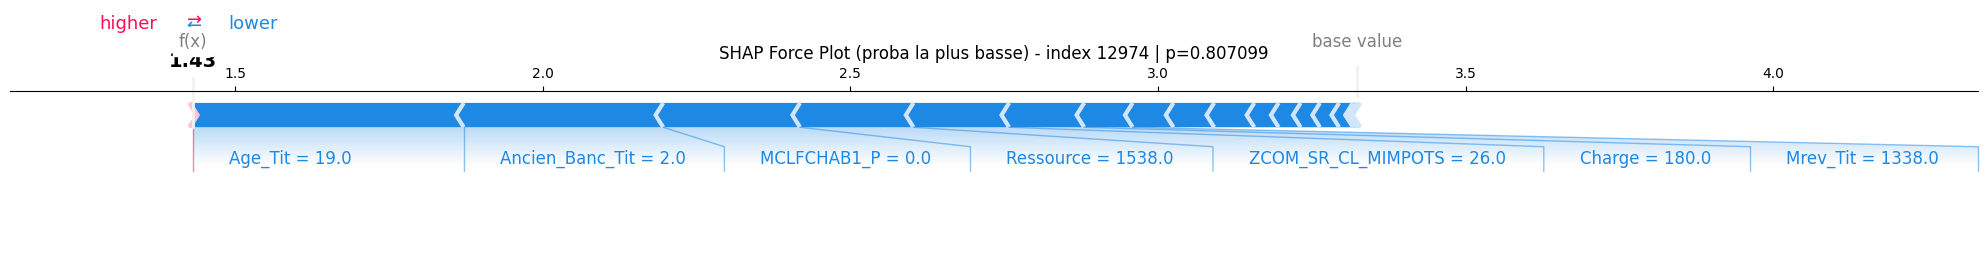

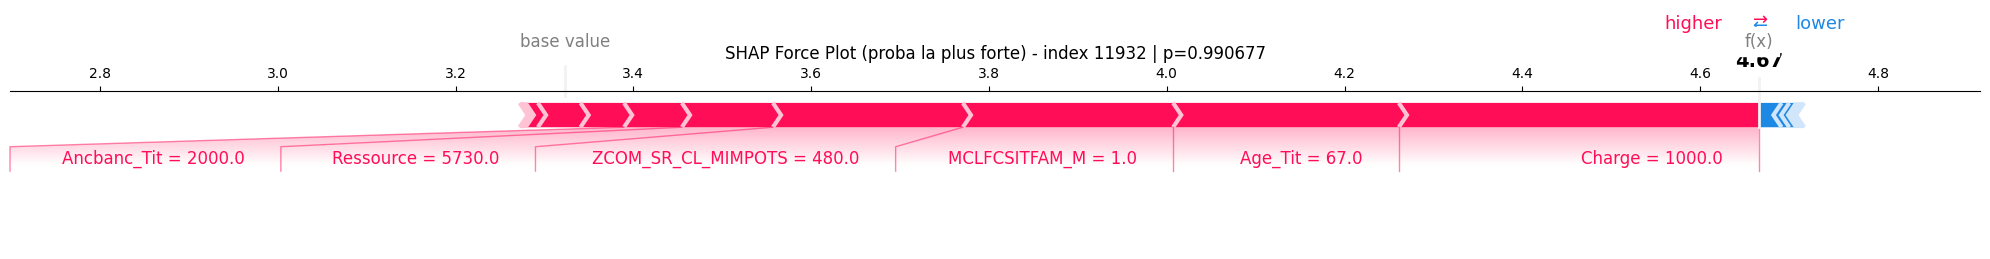

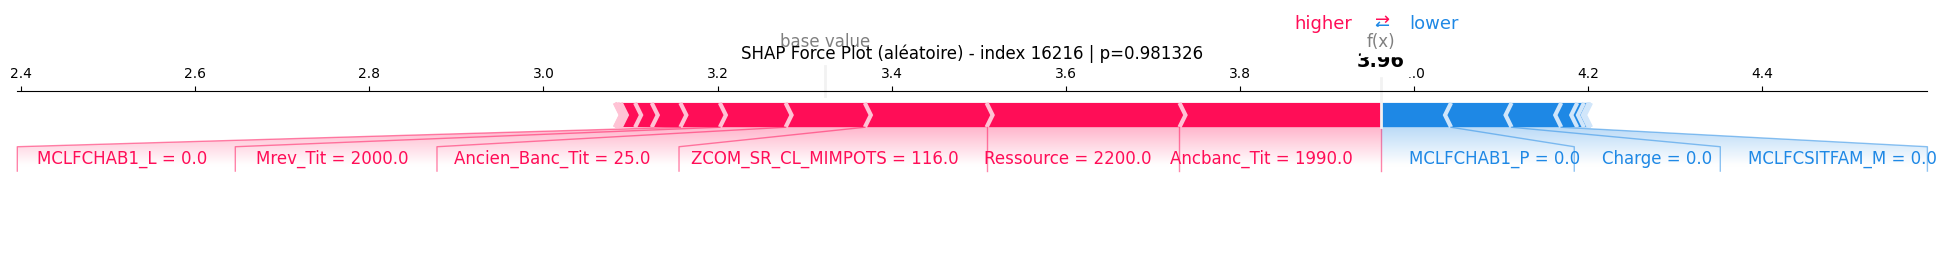

Prédictions sélectionnées + y_test (0 = Mauvais Payeur, 1 = Bon Payeur):


,index,proba,prediction,label,y_test,y_test_label
type,,,,,,
proba_min,12974,0.807099,1,Bon Payeur,1,Bon Payeur
proba_max,11932,0.990677,1,Bon Payeur,1,Bon Payeur
random,16216,0.981326,1,Bon Payeur,1,Bon Payeur


Individu négatif (y_test=0) choisi: index 1635, p=0.984523


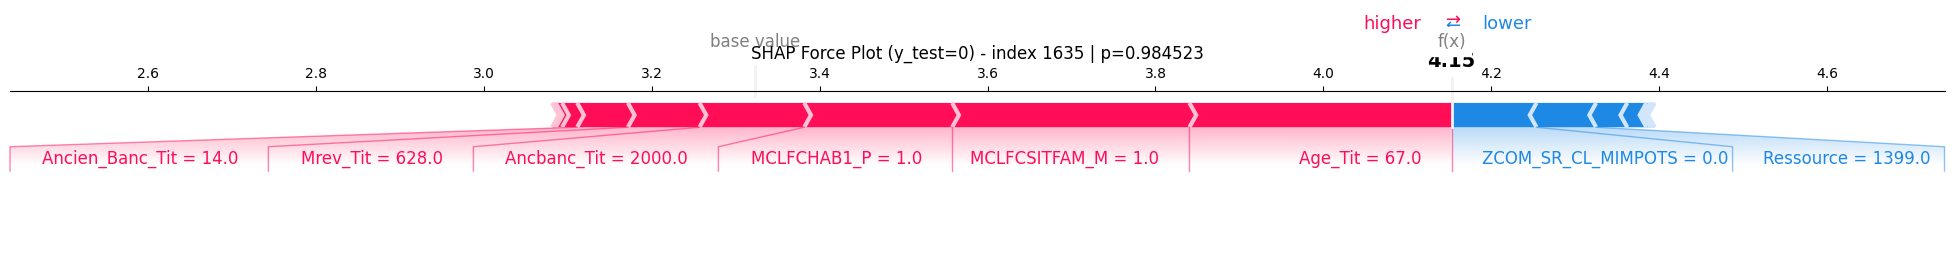

In [ ]:
from scipy.special import expit

# SHAP force plots: min proba, max proba, and random individual

# Préparation des probabilités (utilise d'abord p_pred si déjà calculé en cell 74)
assert 'shap_values' in globals() and 'X_shap' in globals(), "shap_values / X_shap manquants."

if 'p_pred' in globals():
    proba = p_pred
elif 'y_proba_xgb' in globals():
    proba = pd.Series(y_proba_xgb, index=X_shap.index, name="p_test")
elif 'xgb_best' in globals():
    proba = pd.Series(xgb_best.predict_proba(X_shap)[:, 1], index=X_shap.index, name="p_test")
else:
    # fallback: reconstruit la proba via base + somme SHAP (logit -> proba)
    sv = getattr(shap_values, "values", shap_values)
    base = np.array(getattr(shap_values, "base_values", [shap_values.base_values] * len(X_shap))).reshape(-1)
    logit = base + sv.sum(axis=1)
    proba = pd.Series(expit(logit), index=X_shap.index, name="p_test")

# Sélection des index
idx_min = proba.idxmin()
idx_max = proba.idxmax()
rng = np.random.default_rng()
idx_rand = rng.choice(np.array(proba.index))

def _plot_force(idx_label, title_prefix=""):
    # Récupération positionnelle cohérente avec shap_values
    pos = X_shap.index.get_loc(idx_label)
    sv_single = shap_values[pos]
    sample = X_shap.loc[[idx_label]]

    try:
        shap.plots.force(sv_single, matplotlib=True, show=False)
        plt.title(f"{title_prefix} - index {idx_label} | p={proba.loc[idx_label]:.6f}")
        plt.tight_layout()
        plt.show()
    except Exception:
        shap.force_plot(
            getattr(sv_single, "base_values", getattr(shap_values, "base_values", None)),
            getattr(sv_single, "values", sv_single),
            sample,
            feature_names=sample.columns,
            matplotlib=True,
            show=False
        )
        plt.title(f"{title_prefix} (legacy) - index {idx_label} | p={proba.loc[idx_label]:.6f}")
        plt.tight_layout()
        plt.show()

# Plots demandés
_print_min = f"Individu à proba la plus basse: index {idx_min}, p={proba.loc[idx_min]:.6f}"
_print_max = f"Individu à proba la plus forte: index {idx_max}, p={proba.loc[idx_max]:.6f}"
_print_rand = f"Individu aléatoire: index {idx_rand}, p={proba.loc[idx_rand]:.6f}"
print(_print_min)
print(_print_max)
print(_print_rand)

_plot_force(idx_min, "SHAP Force Plot (proba la plus basse)")
_plot_force(idx_max, "SHAP Force Plot (proba la plus forte)")
_plot_force(idx_rand, "SHAP Force Plot (aléatoire)")

# =========================
# Prédictions uniquement pour: proba min, proba max, et aléatoire
# =========================
label_map = {0: "Mauvais Payeur", 1: "Bon Payeur"}

def _pred_for_idx(idx):
    if 'y_pred_xgb' in globals() and len(y_pred_xgb) == len(X_shap):
        pos = X_shap.index.get_loc(idx)
        return int(y_pred_xgb[pos])
    elif 'xgb_best' in globals():
        return int(xgb_best.predict(X_shap.loc[[idx]])[0])
    else:
        return int(proba.loc[idx] >= 0.5)

def _true_for_idx(idx):
    if 'y_test' in globals():
        try:
            return int(y_test.loc[idx])
        except Exception:
            pos = X_shap.index.get_loc(idx)
            return int(y_test.iloc[pos])
    return None

rows = []
for kind, idx in [("proba_min", idx_min), ("proba_max", idx_max), ("random", idx_rand)]:
    pred = _pred_for_idx(idx)
    y_true = _true_for_idx(idx)
    rows.append({
        "type": kind,
        "index": idx,
        "proba": float(proba.loc[idx]),
        "prediction": pred,
        "label": label_map[pred],
        "y_test": y_true,
        "y_test_label": label_map[y_true] if y_true is not None else None
    })

predictions_sel_df = pd.DataFrame(rows).set_index("type")
print("Prédictions sélectionnées + y_test (0 = Mauvais Payeur, 1 = Bon Payeur):")
display(predictions_sel_df)

assert 'y_test' in globals(), "y_test manquant."

try:
    idx_neg_candidates = y_test[(y_test == 0) & y_test.index.isin(X_shap.index)].index
except Exception:
    # Alignement alternatif si index non compatibles
    mask_neg = (pd.Series(y_test).astype(int).values == 0)
    if len(X_shap) == len(y_test):
        idx_neg_candidates = X_shap.index[mask_neg]
    else:
        idx_neg_candidates = pd.Index([])

assert len(idx_neg_candidates) > 0, "Aucun individu avec y_test == 0 trouvé dans X_shap."
idx_neg = rng.choice(np.array(idx_neg_candidates))

print(f"Individu négatif (y_test=0) choisi: index {idx_neg}, p={proba.loc[idx_neg]:.6f}")
_plot_force(idx_neg, "SHAP Force Plot (y_test=0)")

Résumé SHAP (Top features):


,feature,mean_|SHAP|,"spearman(value, SHAP)",ΔP(BP=1) Q90 - Q10
0,ZCOM_SR_CL_MIMPOTS,0.148434,0.829,0.0362
1,MCLFCHAB1_P,0.147679,0.843,0.0259
2,Charge,0.132445,0.428,0.0182
3,MCLFCSITFAM_M,0.118698,0.787,0.0255
4,Ressource,0.118331,0.810,0.0344
5,Age_Tit,0.094176,0.847,0.0641
6,Ancien_Banc_Tit,0.079965,0.702,0.0516
7,Ancbanc_Tit,0.079487,-0.843,-0.0531
8,Mrev_Tit,0.057842,0.665,0.0244
9,MCLFCHAB1_L,0.044067,-0.841,-0.0148


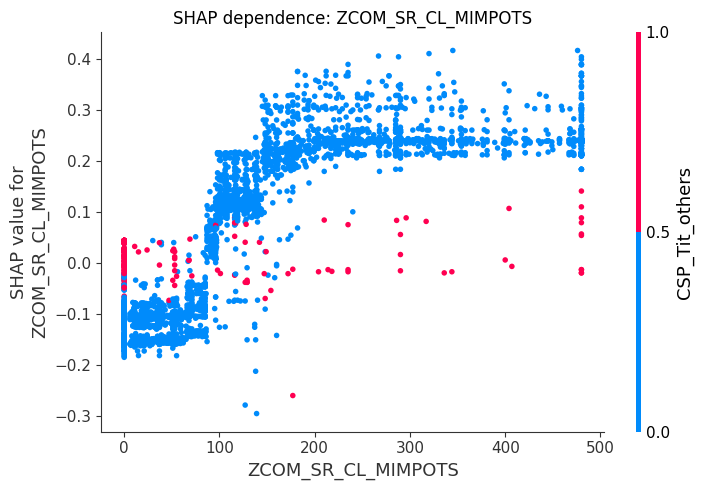

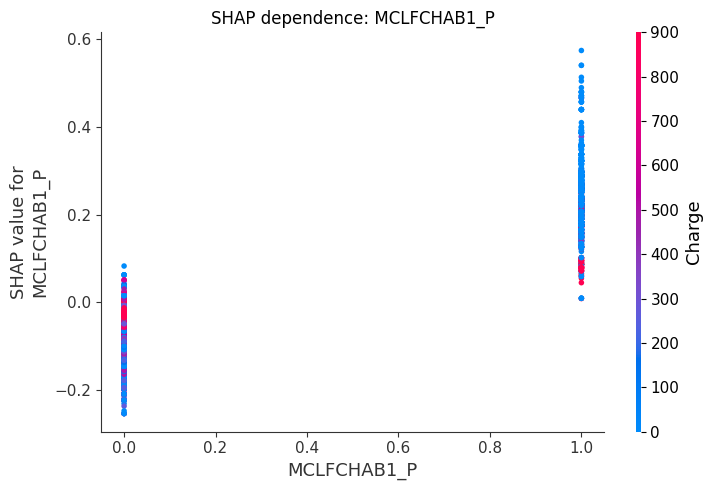

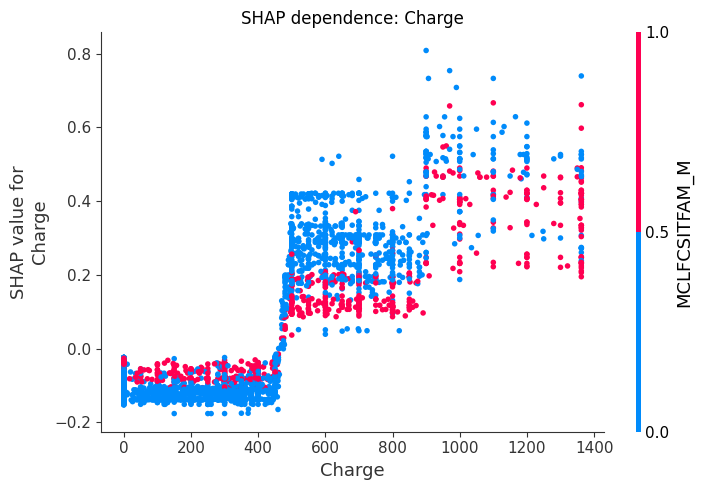

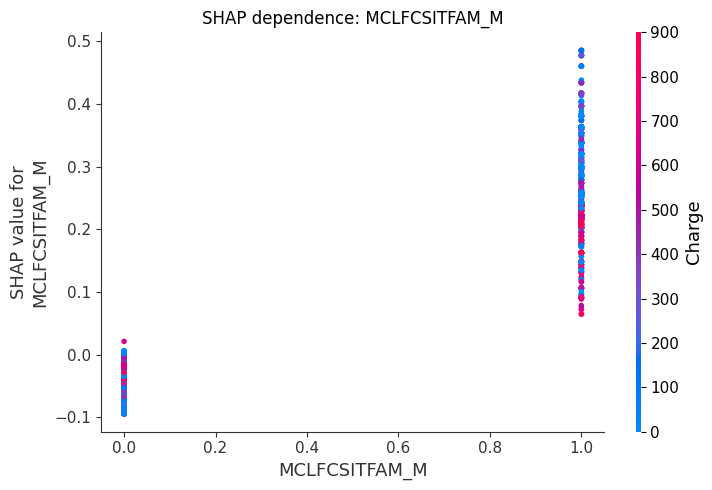

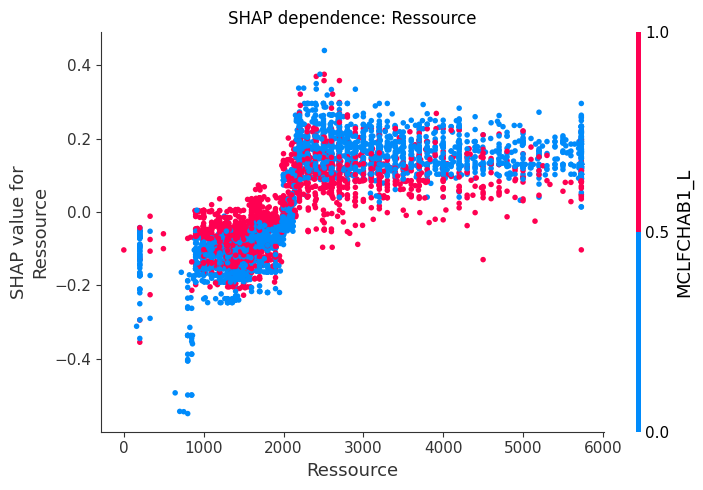

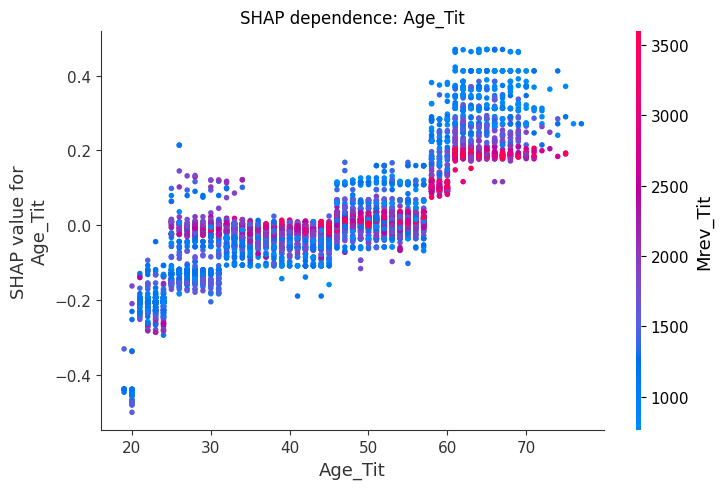

In [ ]:
from scipy.special import expit

# Tableaux utiles
sv = getattr(shap_values, "values", shap_values)  # support anciennes versions
shap_df = pd.DataFrame(sv, columns=X_shap.columns, index=X_shap.index)
base = np.array(getattr(shap_values, "base_values", [shap_values.base_values]*len(X_shap))).reshape(-1)
logit_pred = base + shap_df.sum(axis=1).values
p_pred = pd.Series(expit(logit_pred), index=X_shap.index, name="p_test")

# Top features par importance moyenne absolue
top_feats = shap_df.abs().mean().sort_values(ascending=False).head(12).index.tolist()

rows = []
for f in top_feats:
    # Direction (rho de Spearman entre valeur brute et SHAP): signe => effet moyen
    rho = pd.Series(X_shap[f]).corr(shap_df[f], method="spearman")
    # Effet en proba: diff. de proba moyenne entre quantiles (Q90 vs Q10)
    q10, q90 = X_shap[f].quantile([0.10, 0.90])
    low_mask = X_shap[f] <= q10
    high_mask = X_shap[f] >= q90
    if low_mask.any() and high_mask.any():
        d_proba = float(p_pred[high_mask].mean() - p_pred[low_mask].mean())
    else:
        d_proba = np.nan
    rows.append({
        "feature": f,
        "mean_|SHAP|": shap_df[f].abs().mean(),
        "spearman(value, SHAP)": round(float(rho), 3) if pd.notna(rho) else np.nan,
        "ΔP(BP=1) Q90 - Q10": round(d_proba, 4)
    })

shap_summary_tbl = (pd.DataFrame(rows)
                    .sort_values("mean_|SHAP|", ascending=False)
                    .reset_index(drop=True))

print("Résumé SHAP (Top features):")
display(shap_summary_tbl)

# 6 dépendances détaillées (relation locale + interactions potentielles)
try:
    import shap as _shap
    for f in top_feats[:6]:
        try:
            _shap.dependence_plot(f, shap_values.values if hasattr(shap_values, "values") else shap_values,
                                  X_shap, interaction_index="auto", show=False)
        except Exception:
            _shap.dependence_plot(f, shap_df.values, X_shap, interaction_index=None, show=False)
        plt.title(f"SHAP dependence: {f}")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("Dépendance plots non disponibles:", e)
# ...existing code...

## Save Model

In [ ]:
# ...existing code...
import json, datetime, pathlib, subprocess, hashlib

VERSION = "1.0.0"
BASE_DIR = (pathlib.Path("..") / "service" / "artifacts" / f"model_v{VERSION}")
BASE_DIR.mkdir(parents=True, exist_ok=True)

# 1. Modèle
xgb_best.save_model(BASE_DIR / "model_xgb.json")

# 2. Meta
meta = {
    "model_type": "xgboost",
    "model_version": VERSION,
    "created_at": datetime.datetime.utcnow().isoformat()+"Z",
    "var_model": var_model,
    "threshold": 0.5,
    "metrics": {
        "auc_test": float(auc_xgb_test),
        "gini_test": float(gini_xgb_test)
    }
}
with open(BASE_DIR / "model_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

# 3. Schéma (types attendus)
dtype_map = {}
for c in var_model:
    dt = str(X_train[c].dtype)
    if dt.startswith("int"):
        dtype_map[c] = "int"
    elif dt.startswith("float"):
        dtype_map[c] = "float"
    else:
        dtype_map[c] = "float"
schema = {
    "generated_at": datetime.datetime.utcnow().isoformat()+"Z",
    "dtypes": dtype_map,
    "primary_key": None
}
with open(BASE_DIR / "schema.json", "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)

# 4. Jeu de référence
X_test[var_model].to_parquet(BASE_DIR / "reference.parquet")

# 5. Freeze des dépendances
req_text = subprocess.check_output(["pip", "freeze"], text=True)
(BASE_DIR / "requirements.freeze.txt").write_text(req_text, encoding="utf-8")

# 6. Fichier VERSION
(BASE_DIR / "VERSION").write_text(VERSION, encoding="utf-8")

# 7. Hash d’intégrité
hash_lines = []
for p in BASE_DIR.iterdir():
    if p.is_file():
        h = hashlib.sha256(p.read_bytes()).hexdigest()
        hash_lines.append(f"{h}  {p.name}")
(BASE_DIR / "SHA256SUMS").write_text("\n".join(hash_lines), encoding="utf-8")

print("Artifacts sauvés dans :", BASE_DIR.resolve())
# ...existing code...